In [52]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, IMG_pull, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20 and AGN == "-"')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')


In [38]:
field = 'GSD'
galaxies =41520

grow = morph_db.query('id == {0}'.format(galaxies))

Gs = Gen_spec(field, galaxies, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec(field, galaxies)

x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxies))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxies))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [6]:
lowlim = 1
z5_errbin_ls = []
z5_errbin_hs = []

while lowlim < 9:
    print(lowlim)
    
    if lowlim < 5:
        addage = 2
    else:
        addage = 4

    lowerr = []
    hierr = []
    for i in mdb.index:
        lowerr.append(cosmo.lookback_time(mdb.z_50_hci[i][0]).value)
        hierr.append(cosmo.lookback_time(mdb.z_50_hci[i][1]).value)
       
    z5_errbin_hs.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    if lowlim < 5:
        lowlim += addage
    else:
        lowlim += addage
lowlim = 1
       
while lowlim < 9:
    print(lowlim)
    
    if lowlim < 5:
        addage = 2
    else:
        addage = 4

    
    lowerr = []
    hierr = []
    for i in mdb.index:
        lowerr.append(cosmo.lookback_time(mdb.z_50_hci[i][0]).value)
        hierr.append(cosmo.lookback_time(mdb.z_50_hci[i][1]).value)
       
    z5_errbin_ls.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    if lowlim < 5:
        lowlim += addage
    else:
        lowlim += addage

1
3
5
1
3
5


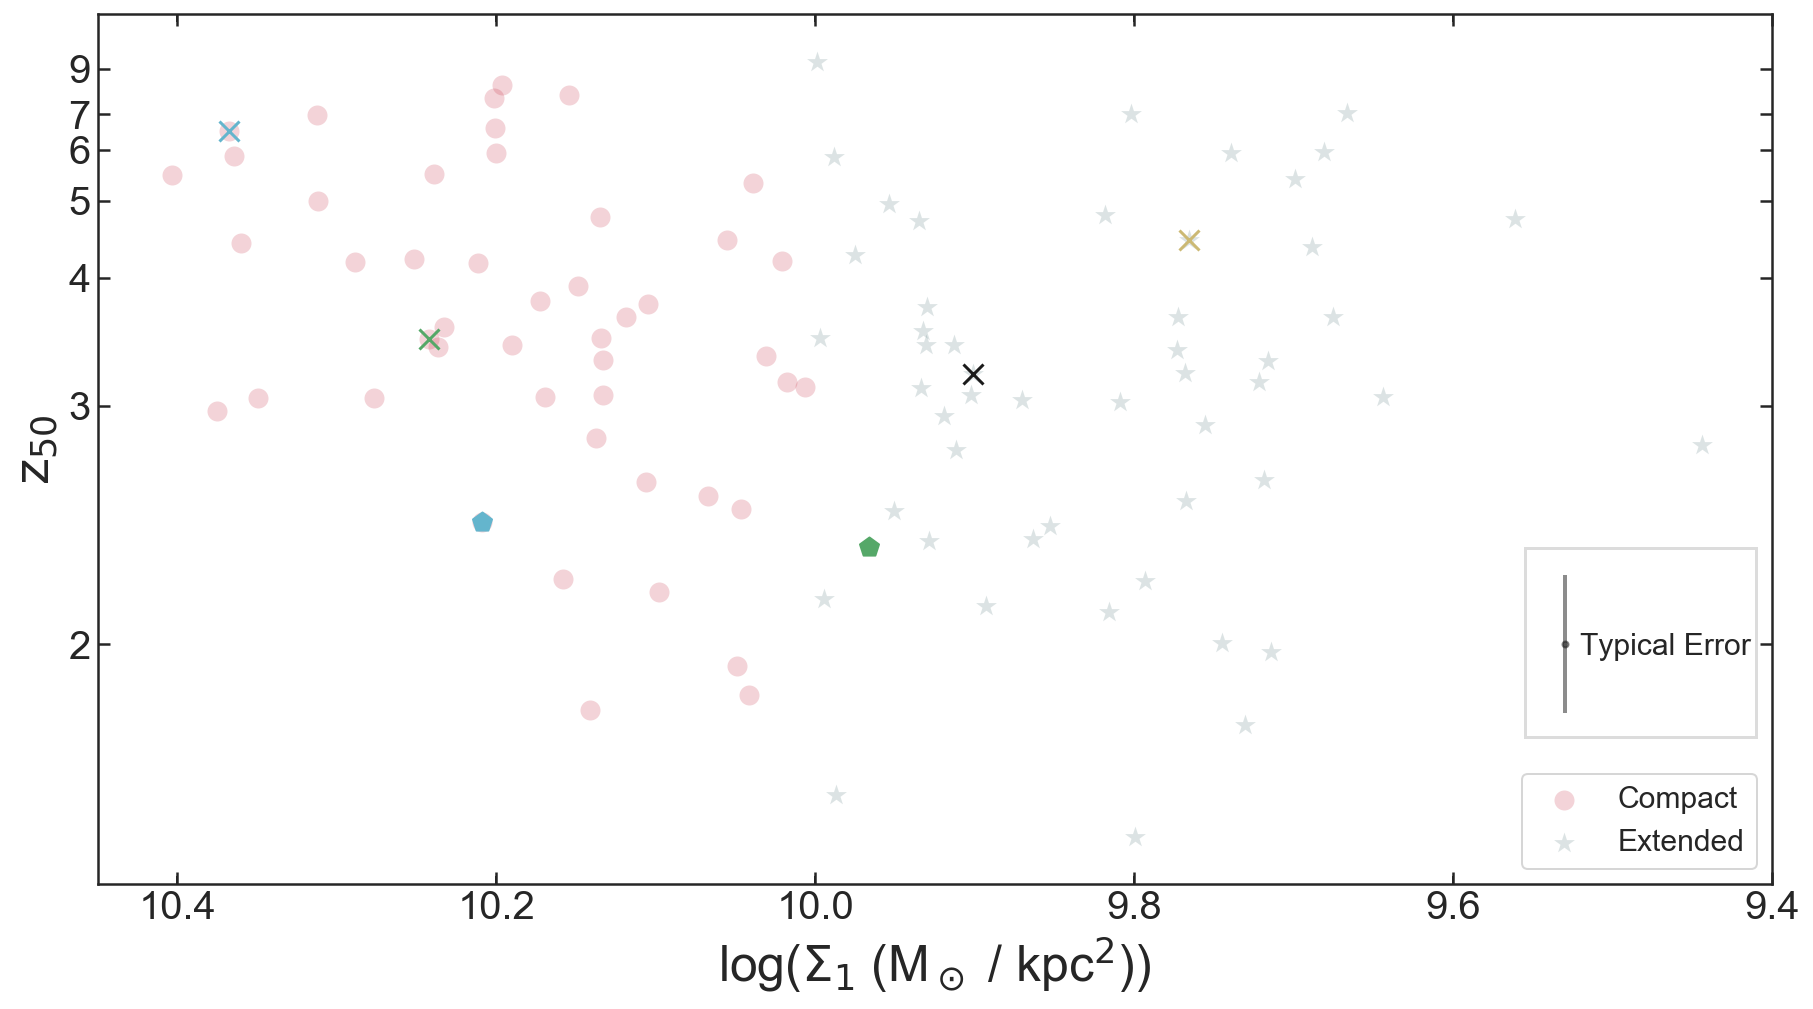

In [54]:
from matplotlib.patches import FancyBboxPatch


plt.figure(figsize=[15,8])

ax1 = plt.subplot()

sea.scatterplot(np.log10(mdb.query('Sigma1 > 10**10').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 > 10**10').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#C4253C', s = 100, marker = 'o', label = 'Compact', alpha =0.2)

sea.scatterplot(np.log10(mdb.query('Sigma1 < 10**10').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 < 10**10').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#507678', s = 120, marker = '*', label = 'Extended', alpha =0.2)

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_yticklabels([2,3,4,5,6,7,9])
ax1.minorticks_off()

ax1.set_xticks([ 10.4, 10.2, 10.0, 9.8, 9.6], minor=True)
plt.xlim(10.45,9.4)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=15, loc = 4)

rleg =plt.Rectangle((9.41, cosmo.lookback_time(1.75).value), 0.145,  0.9,
                     ec='k', fc='none', linewidth=1.5, alpha = 0.15)

ax1.add_artist(rleg)

plt.errorbar(9.53,cosmo.lookback_time(2).value, yerr=z5_errbin_ls[0], fmt = '.', ecolor = 'k',  color = 'k',
            elinewidth = 2, alpha = 0.5)
plt.text(9.52,cosmo.lookback_time(1.97).value, 'Typical Error', fontsize = 15)

exids =[39170, 21156, 40862,45972, 40597, 39850]

cols = ['c','g','k','y','c','g']
mrks = ['x','x','x','x','p','p']

for i in range(len(exids)):
    for ii in mdb.index:
        if mdb.id[ii] == exids[i]:
            plt.scatter(np.log10(mdb.Sigma1[ii]), cosmo.lookback_time(mdb.z_50[ii]),
                       color = cols[i], marker = mrks[i], s =100)


# plt.savefig('../plots/presentation_plots/compact_sig1_lim.png', bbox_inches = 'tight')

In [34]:
mdb.query('z_50 < 2.5 and zgrism > 0.9')[['field','id', 'Sigma1', 'z_50', 'zgrism']]

field     id        Sigma1      z_50    zgrism
0    GND  12078  7.814666e+09  2.117355  1.016371
4    GND  14158  5.180422e+09  1.977476  0.910859
21   GND  26673  6.543581e+09  2.100232  0.941677
33   GND  36348  9.868666e+09  2.141385  1.089329
55   GSD  39850  9.253919e+09  2.328142  0.979554
56   GSD  40476  8.921335e+09  2.471527  1.212179
57   GSD  40597  1.618357e+10  2.424933  1.218653

In [32]:
### 40597, 40476, 39850, 
### 1.218653, 1.212179,0.979554

## 44620, 45972

9.9504298476218

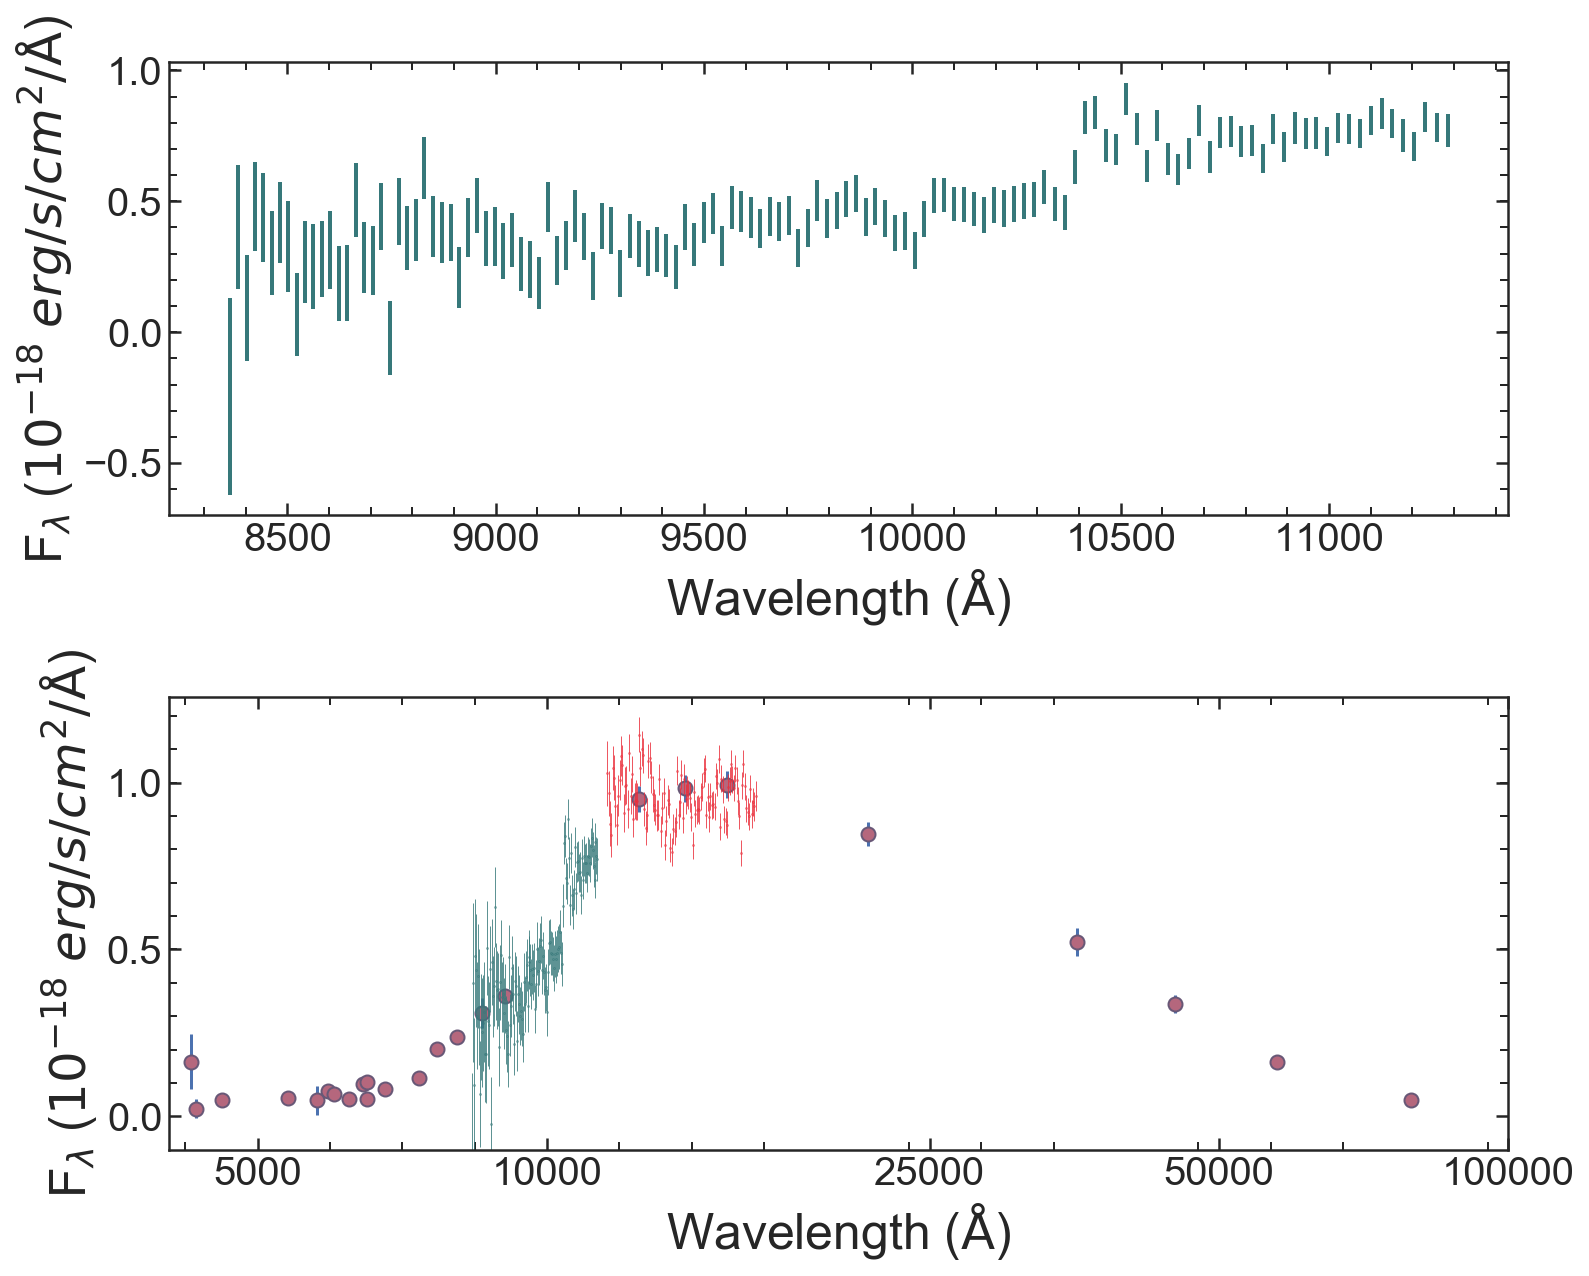

In [39]:
gs = gridspec.GridSpec(2,1, hspace=0.4)

plt.figure(figsize= [12,10])
##############plot tab##################
plt.subplot(gs[0])
plt.errorbar(Gs.Bwv,Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.5, color='#36787A', zorder = 2, elinewidth = 2)

plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()

plt.subplot(gs[1])
plt.errorbar(np.log10(Gs.Bwv),Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

plt.errorbar(np.log10(Gs.Rwv),Gs.Rfl *1E18,Gs.Rer *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)

plt.errorbar(np.log10(Gs.Pwv),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

plt.xlim(np.log10(min(Gs.Pwv)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
plt.ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

plt.xticks(np.log10([5000,10000,25000, 50000, 100000]),np.array([5000,10000,25000, 50000, 100000]))
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
plt.savefig('../plots/presentation_plots/41520_2spec.png', bbox_inches = 'tight')

In [115]:
sfh = Rescale_sfh('GSD',41520)

In [128]:
from spec_tools import Gen_PPF

class Sfh_prior_single(object):
    def __init__(self, field, galaxy, a, lm,trials = 1000):

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = get_agebins(a).flatten()
        sfr_grid = []

        while idx < trials:
            taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
            masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))

            time, sfr, tmax = convert_sfh(get_agebins(a), masses, maxage = a*1E9)

            lbt = np.abs(time - time[-1])[::-1]
            lbsfr = sfr[::-1]

            sfr_grid.append(lbsfr)

            idx +=1
        SFH = []
        SFH_16 = []
        SFH_84 = []
        SFH_250 = []
        SFH_975 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            SFH.append(np.percentile(adat,50))
            SFH_16.append(np.percentile(adat,16))
            SFH_84.append(np.percentile(adat,84))
            SFH_250.append(np.percentile(adat,2.5))
            SFH_975.append(np.percentile(adat,97.5))
            
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.SFH_250 = np.array(SFH_250)
        self.SFH_975 = np.array(SFH_975)
        self.LBT = np.array(lbt)
        
        self.sfr_grid = np.array(sfr_grid)

In [137]:
prior = Sfh_prior_single('GSD',41520,max(sfh.fulltimes), mdb.query('id == 41520').lmass.values[0], trials=5000)

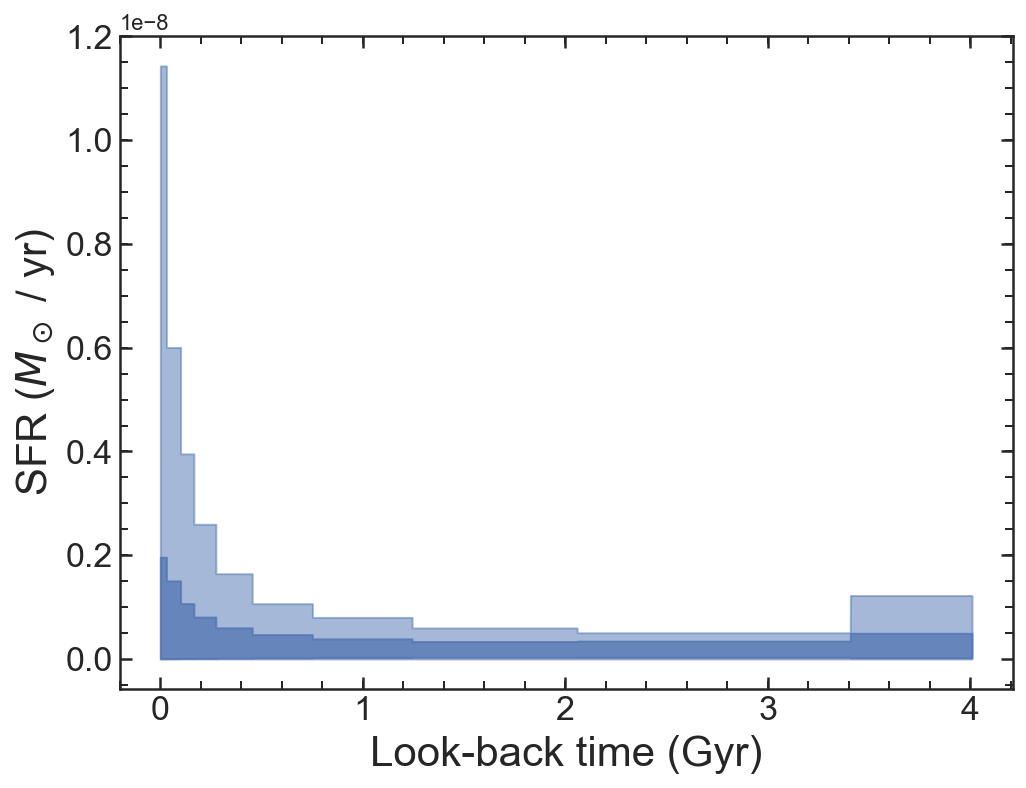

In [144]:
plt.figure(figsize= [8,6])

# plt.plot(sfh.fulltimes, sfh.sfr_grid[2], color = '#532436', linewidth = 5)
plt.xlabel('Look-back time (Gyr)', fontsize=21)
plt.ylabel('SFR ($M_\odot$ / yr)', fontsize=21)   
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()

rns = [1,34,5,238,12,885]

# for r in rns:
# plt.plot(prior.LBT, prior.sfr_grid[195], linewidth = 2 ,alpha = 0.9)
# plt.plot(prior.LBT, prior.sfr_grid[916], linewidth = 2 ,alpha = 0.9)
# plt.plot(prior.LBT, prior.sfr_grid[971], linewidth = 2 ,alpha = 0.9)
# plt.plot(prior.LBT, prior.sfr_grid[981], linewidth = 2 ,alpha = 0.9)
plt.fill_between(prior.LBT, prior.SFH_975, prior.SFH_250, alpha = 0.5, color = 'b')

plt.fill_between(prior.LBT, prior.SFH_84, prior.SFH_16, alpha = 0.7, color = 'b')

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0.4E-14,0.4E-8)
# plt.savefig('../plots/presentation_plots/sfh_example.png', bbox_inches = 'tight')

In [59]:
a = 4
lm=11

taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))

time, sfr, tmax = convert_sfh(get_agebins(a), masses, maxage = a*1E9)


T=[0]
M=[0]
for i in range(len(time)//2):
    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
    M.append(M[i] + mass)
    T.append(time[i*2+1])

    
sfr = sfr/ M[-1] * 10**lm / 1E9

print(sfr)

lbt = np.abs(time - time[-1])[::-1]
lbsfr = sfr[::-1]

sfr_grid.append(lbsfr)

[31.10285558 31.10285558 36.63430524 36.63430524 15.67269379 15.67269379
 13.46444731 13.46444731  6.97857492  6.97857492 14.66545925 14.66545925
 24.29496482 24.29496482 25.32952592 25.32952592 50.80005573 50.80005573
  6.41436403  6.41436403]


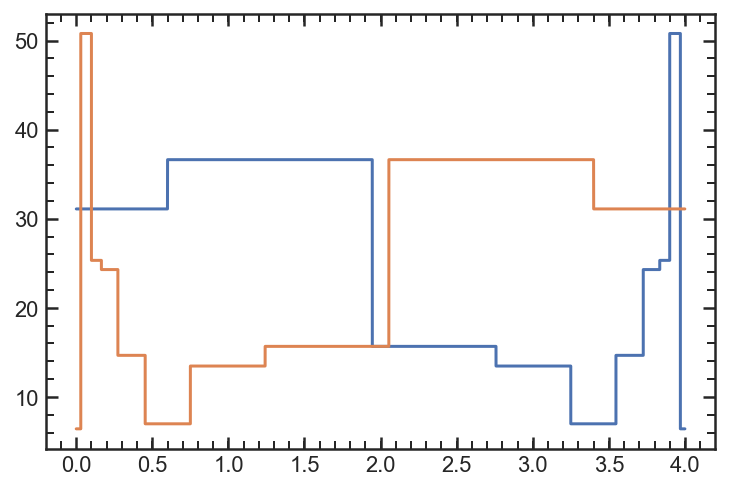

In [61]:
plt.plot(time,sfr)
plt.plot(lbt,lbsfr)

In [49]:

def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

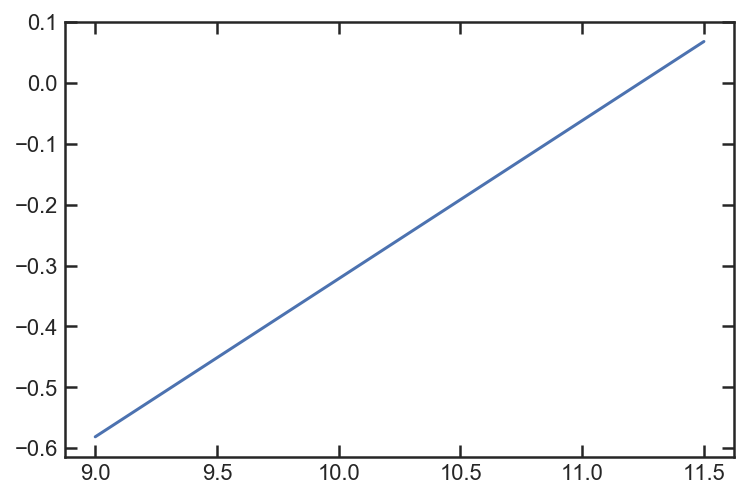

In [51]:
plt.plot(np.linspace(9.0,11.5), Z_prior_mu(np.linspace(9.0,11.5)))

In [14]:
from spec_tools import Gen_PPF

class Sfh_prior(object):
    def __init__(self, field, galaxy, trials = 1000):

        ppf_dict = {}
        params = ['a', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []

        while idx < trials:
            draw = np.zeros(len(params))

            for i in range(len(draw)):
                draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                
            taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
            masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(draw[0]))
    
            time, sfr, tmax = convert_sfh(get_agebins(draw[0]), masses, maxage = draw[0]*1E9)

        
            T=[0]
            M=[0]
            for i in range(len(time)//2):
                mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                M.append(M[i] + mass)
                T.append(time[i*2+1])

            sfr = sfr/ M[-1] * 10**draw[1] / 1E9
        
            lbt = np.abs(time - time[-1])[::-1]
            lbsfr = sfr[::-1]
        
            sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

            idx +=1
        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])

        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.array(sfr_grid)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestra

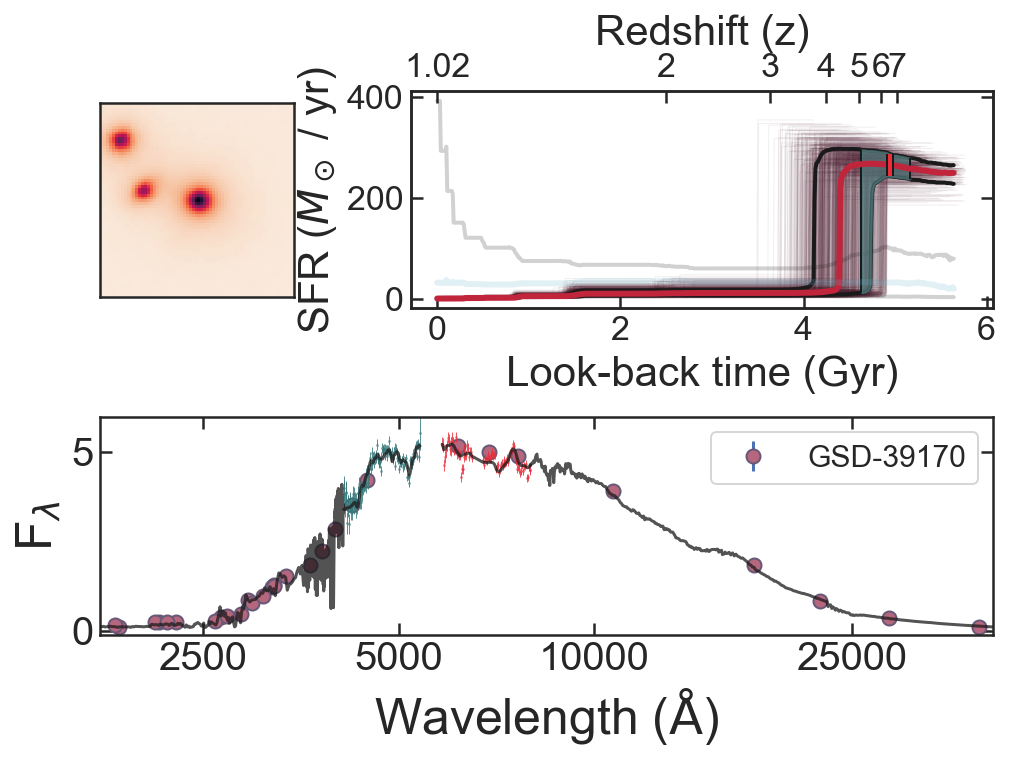

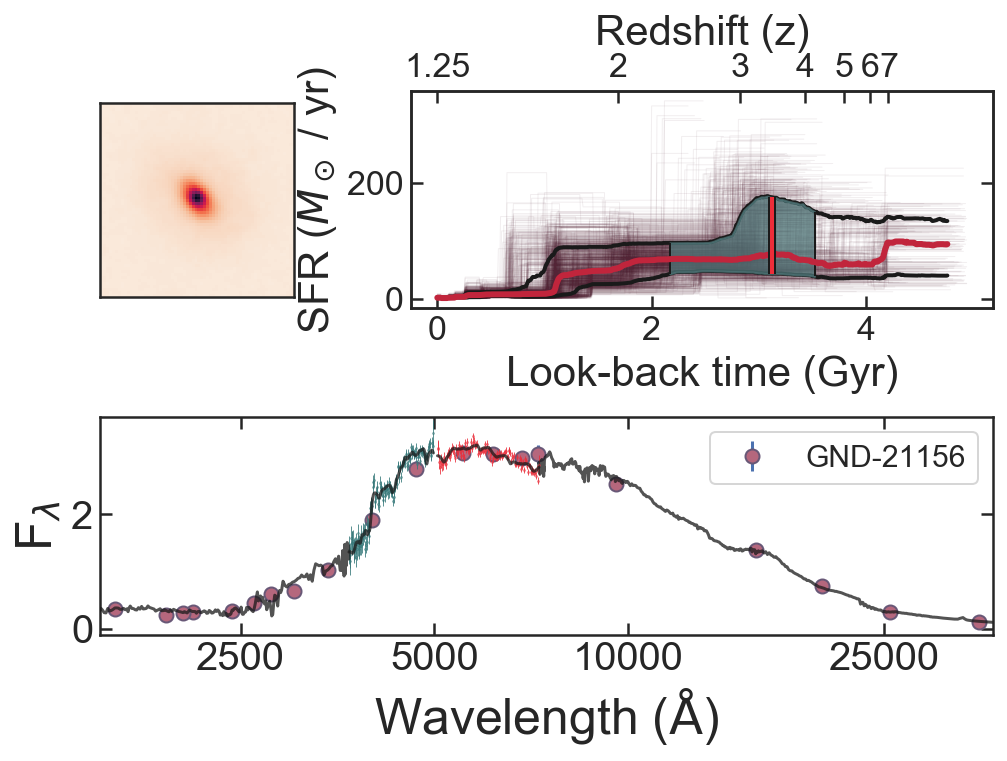

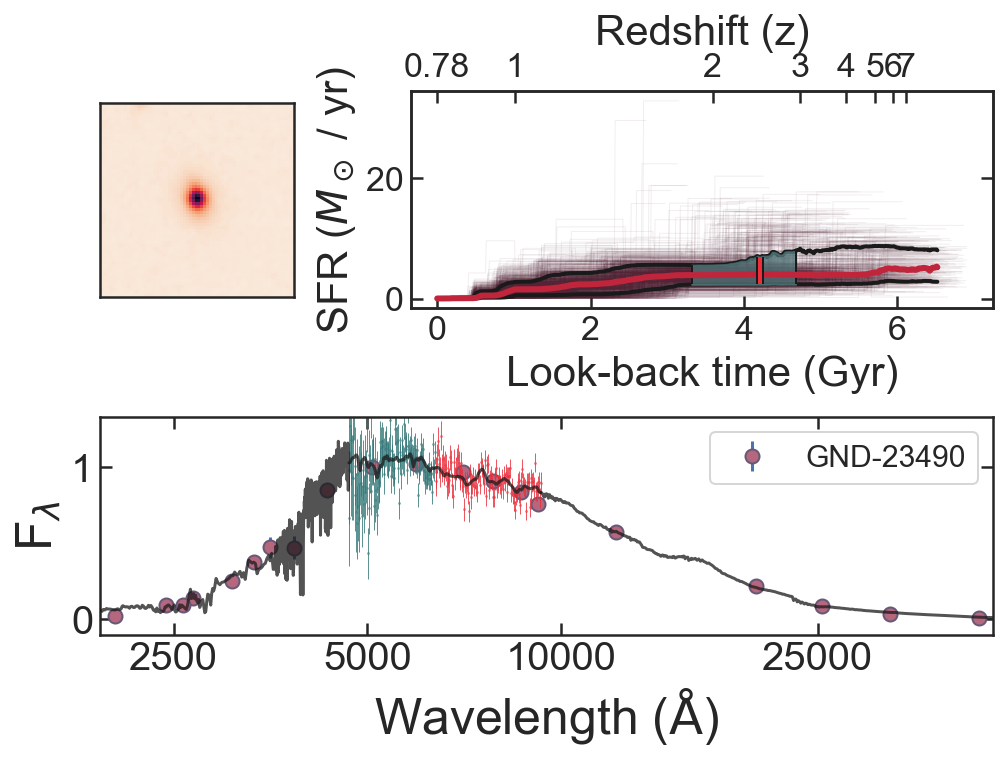

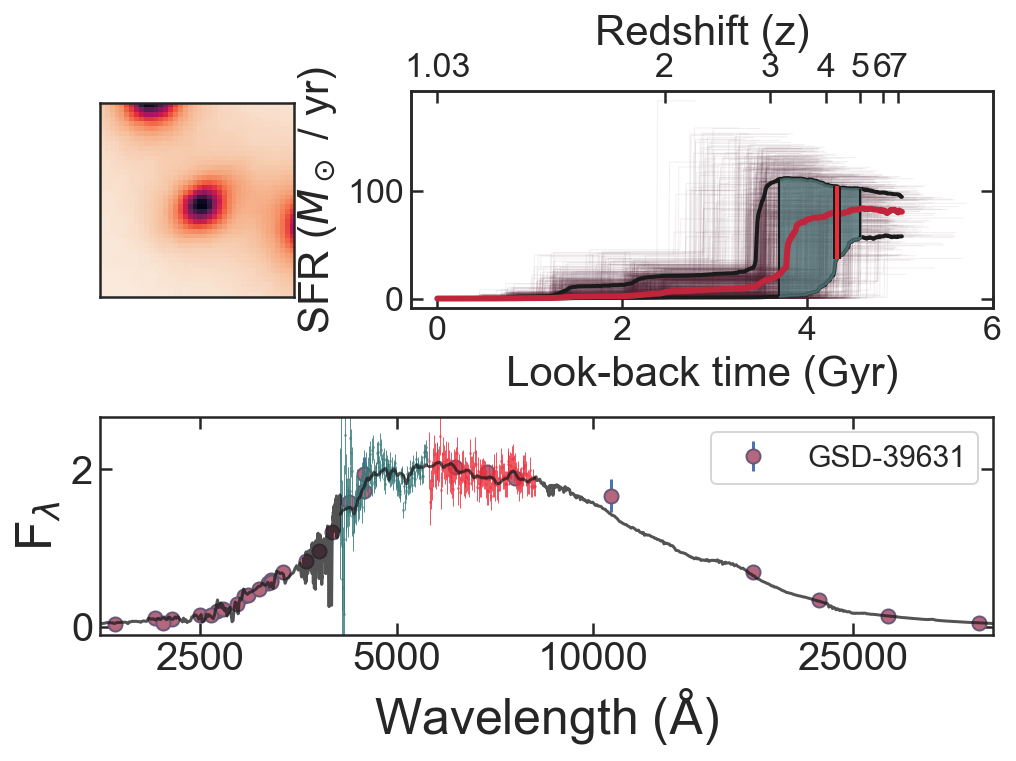

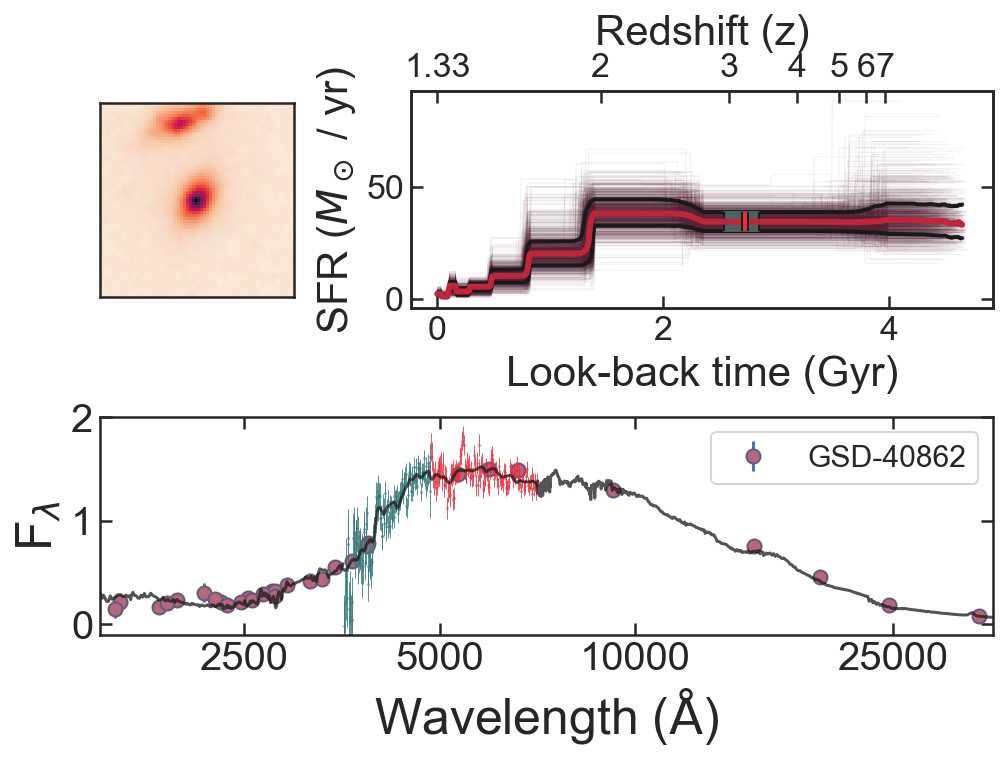

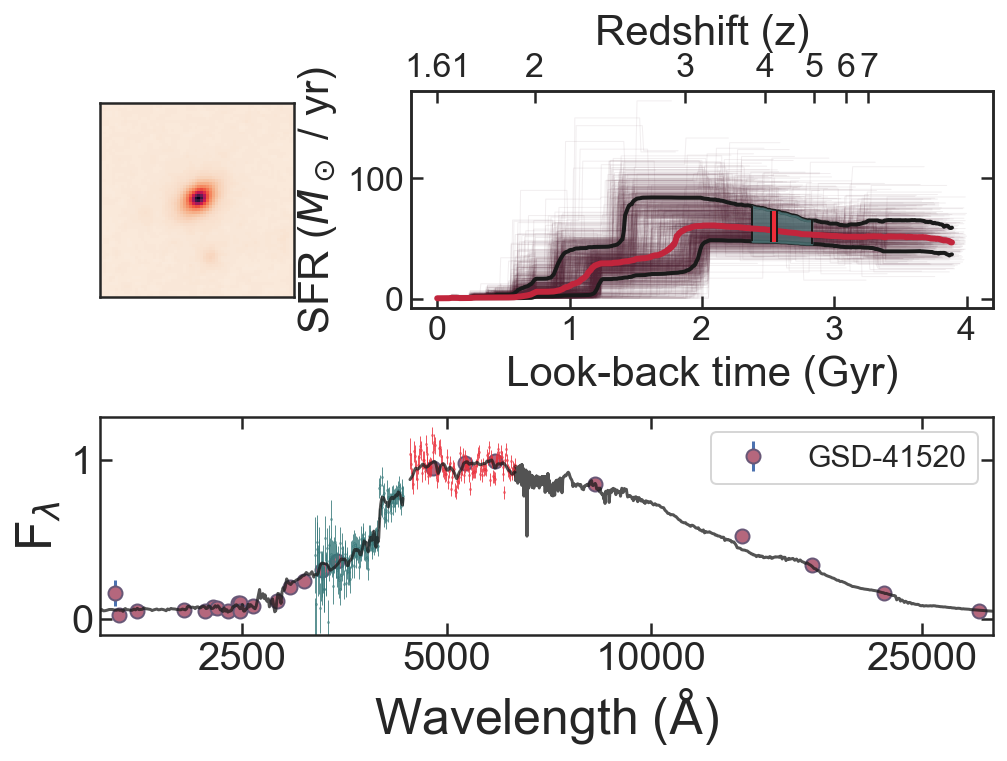

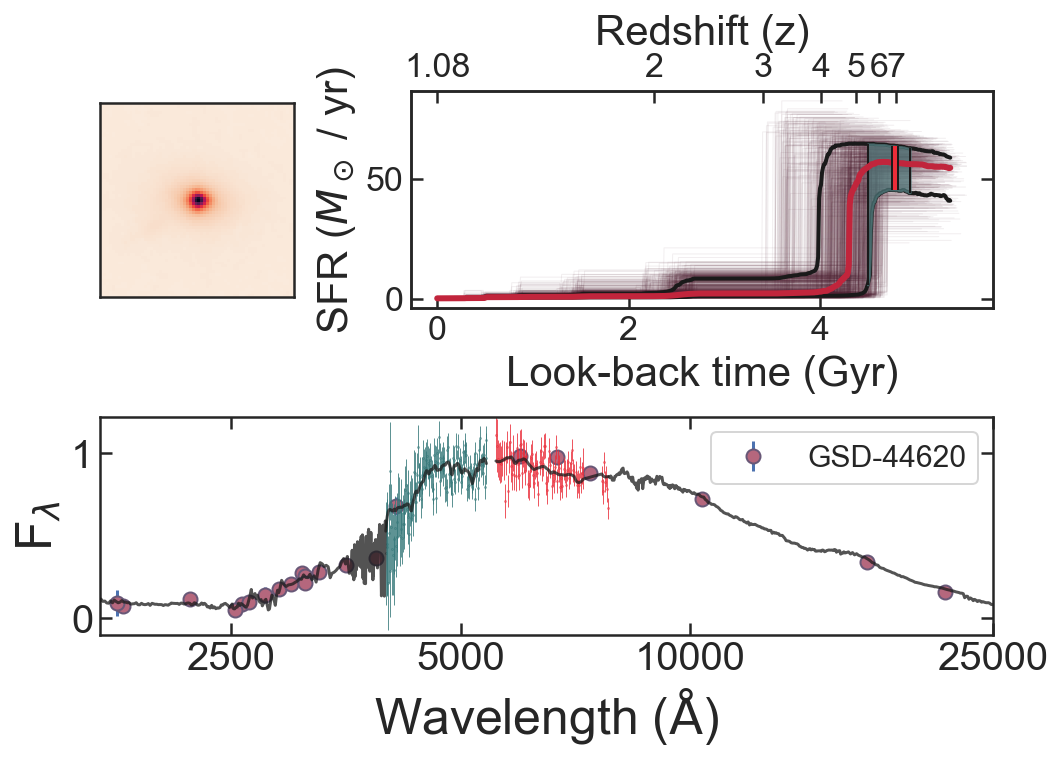

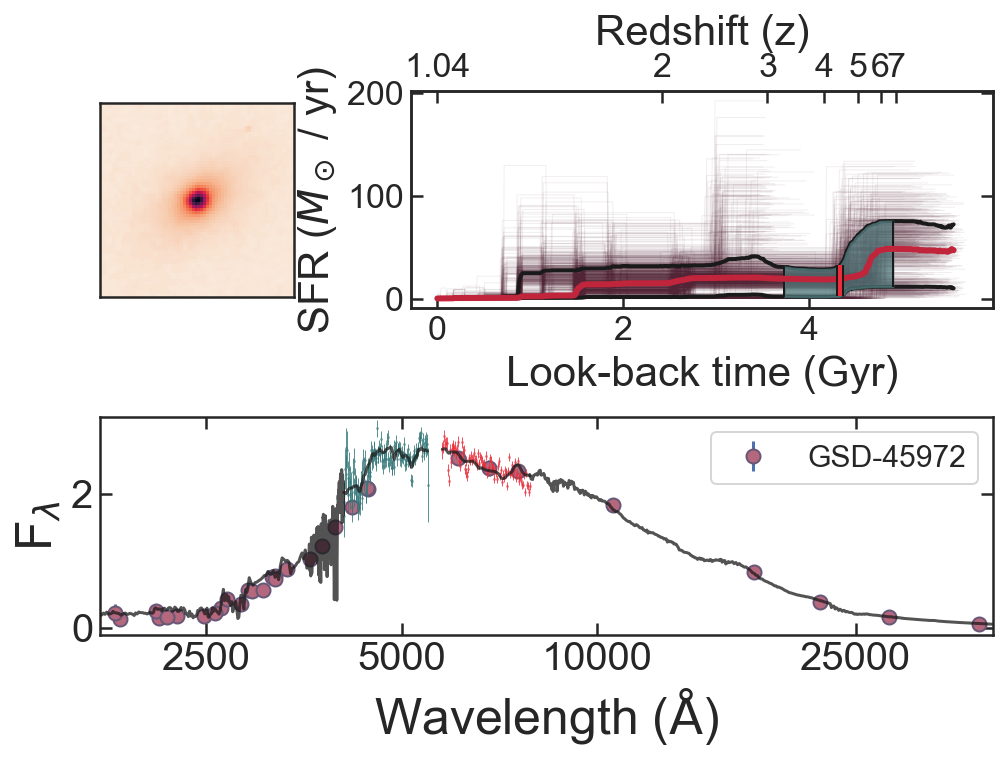

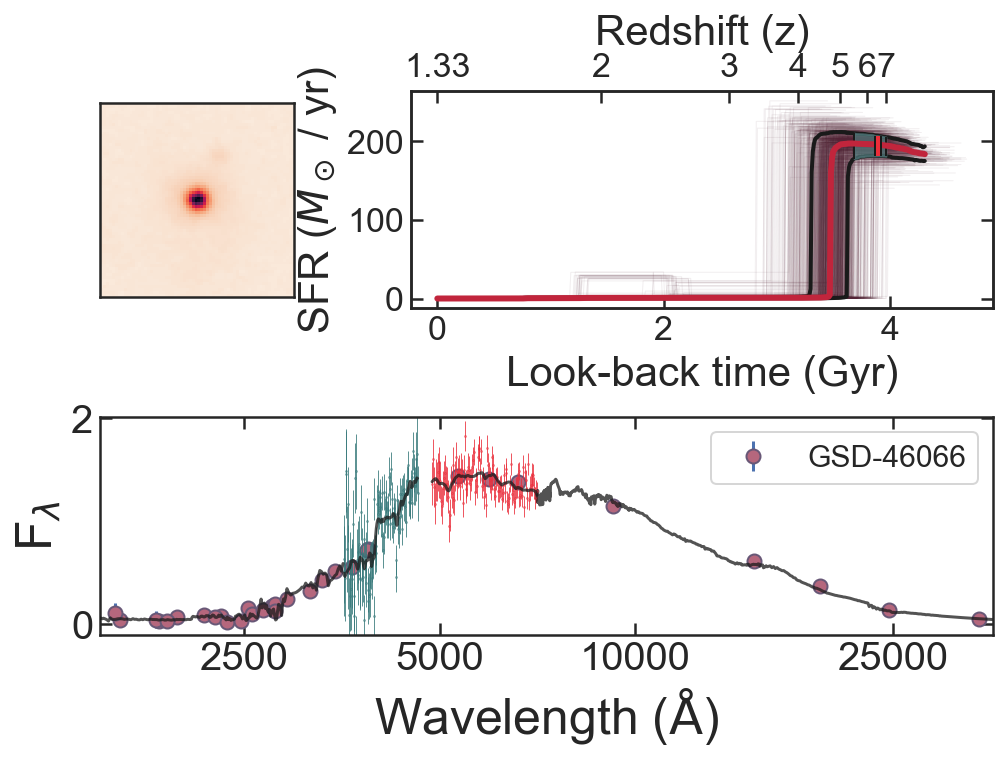

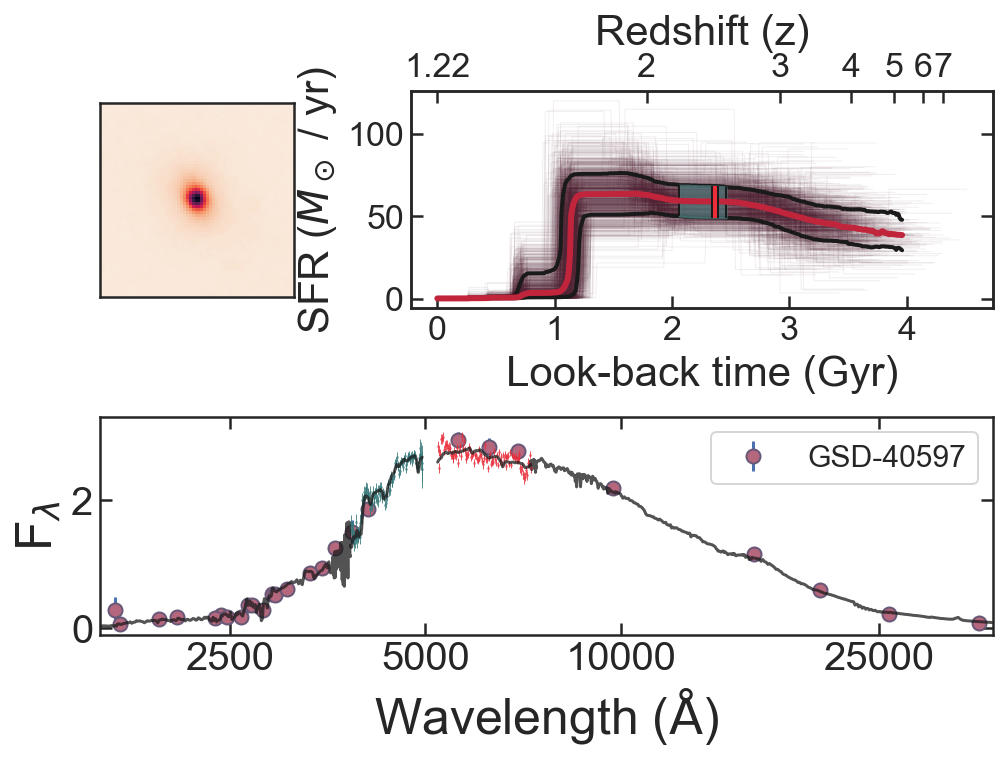

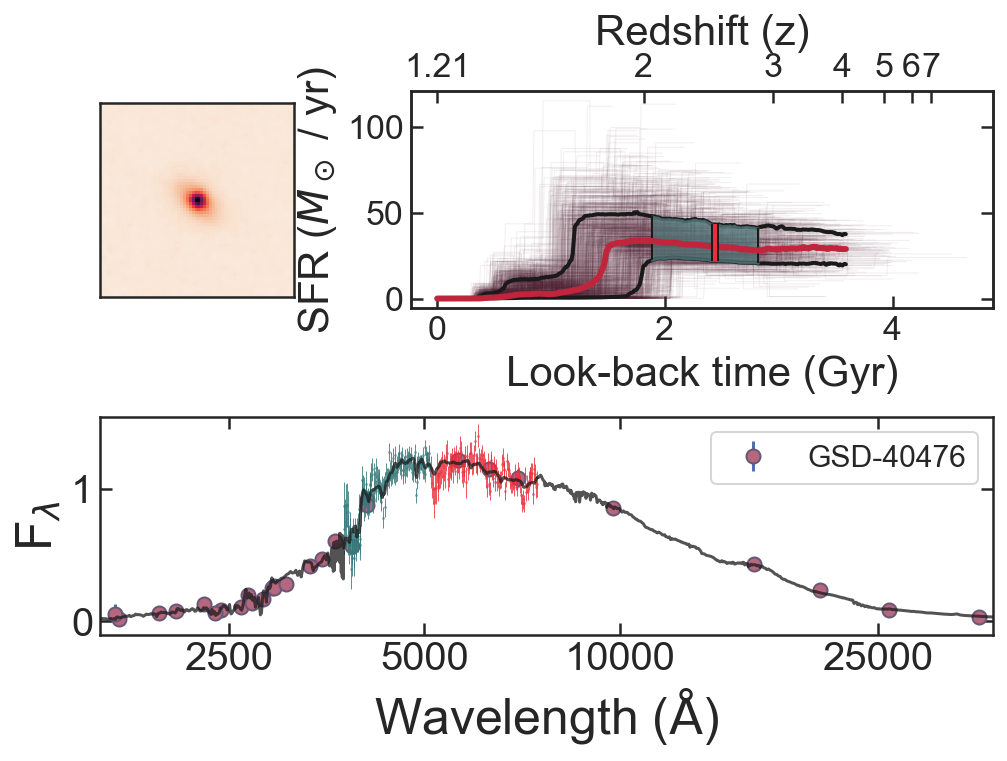

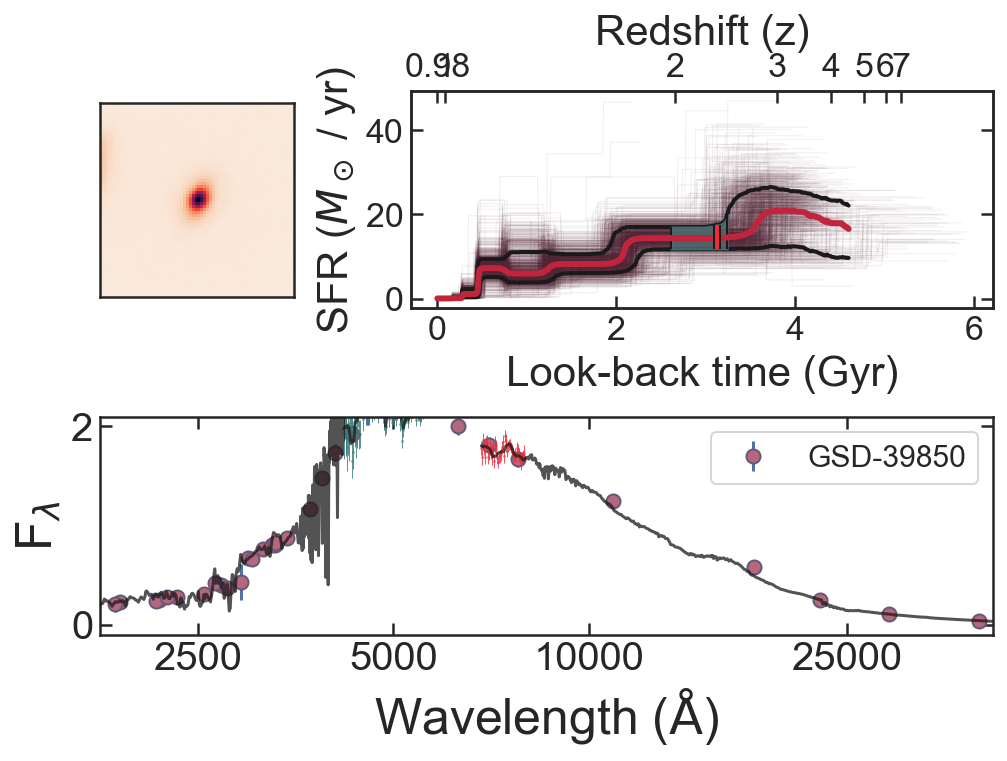

In [36]:
galaxies = [39170, 21156, 23490, 39631, 40862, 41520, 44620, 45972, 46066, 40597, 40476, 39850]
field = ['GSD', 'GND', 'GND',  'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD']

flip = True

for i in range(12):
    plt.figure(figsize =[8,5])
    
    gsin = gridspec.GridSpec(2,2, width_ratios=[1,3], hspace=0.5, wspace=0.3)

    grow = morph_db.query('id == {0}'.format(galaxies[i]))

    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field[i], galaxies[i]))

    ax1 = plt.subplot(gsin[0,0])
    ax1.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = plt.subplot(gsin[1,:])

    Gs = Gen_spec(field[i], galaxies[i], grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field[i], galaxies[i])

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field[i], galaxies[i]))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field[i], galaxies[i]))
    rp1 = x[px == max(px)][0]

    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field[i], galaxies[i])

    ##############plot tab##################

    if Gs.g102:
        ax2.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

    if Gs.g141:
        ax2.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    ax2.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1, label = '{0}-{1}'.format(field[i], galaxies[i]))

    ax2.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
    ax2.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
    ax2.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
    ax2.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

    ax2.set_xticks(np.log10([2500,5000,10000,25000]))
    ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
    ax2.legend(fontsize=15, frameon = True, loc = 1)
    ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
    ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=20)

    ax3 = plt.subplot(gsin[0,1])

    isfhl = interp1d(sfh.LBT,sfh.SFH_16)
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)

    ax4 = ax3.twiny()

    ax3.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
    ax3.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
    ax3.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax3.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

    if flip:  
        prior = Sfh_prior(field[i], galaxies[i])

        ax3.plot(prior.LBT,prior.SFH, color = 'c', linewidth = 3, zorder = 9, alpha = 0.2)
        ax3.plot(prior.LBT,prior.SFH_16, 'k', linewidth = 2, alpha = 0.2)
        ax3.plot(prior.LBT,prior.SFH_84, 'k', linewidth = 2, alpha = 0.2)
        flip = False
    
    
    max_lbt = np.round(sfh.fulltimes[-1])
    max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
    age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
    zarray = [np.round(grow.zgrism.values[0],2)]

    idx = 0
    while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
        zarray.append(int(zarray[idx])+1)
        idx += 1 

    tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

    ax4.set_xlim(ax3.get_xlim())
    ax4.set_xticks(tarray)
    ax4.set_xticklabels(zarray)
    ax4.xaxis.set_ticks_position('top')

    ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
    ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
    ax4.set_xlabel('Redshift (z)', fontsize=21) 
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

    hdr = np.linspace(grow.t_50_hci.values[0][0],grow.t_50_hci.values[0][1])

    ax3.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][0],isfhl(grow.t_50_hci.values[0][0]),isfhh(grow.t_50_hci.values[0][0]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][1],isfhl(grow.t_50_hci.values[0][1]),isfhh(grow.t_50_hci.values[0][1]), 
               color = 'k', linewidth = 1, zorder = 8)

    plt.savefig('../plots/presentation_plots/sfh_gmt_{}_{}.png'.format(field[i], galaxies[i]), bbox_inches = 'tight')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


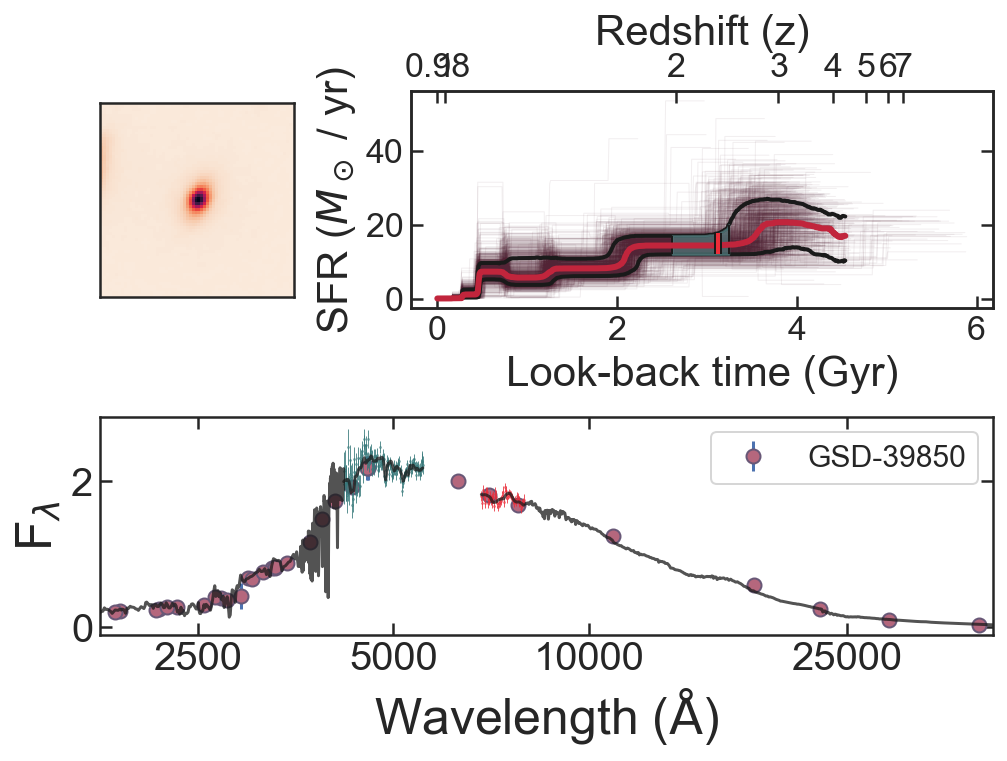

In [42]:
galaxies = 39850
field = 'GSD'

plt.figure(figsize =[8,5])
gsin = gridspec.GridSpec(2,2, width_ratios=[1,3], hspace=0.5, wspace=0.3)

grow = morph_db.query('id == {0}'.format(galaxies))

rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field, galaxies))

ax1 = plt.subplot(gsin[0,0])
ax1.imshow(-np.arcsinh(rsimg))
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(gsin[1,:])

Gs = Gen_spec(field, galaxies, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec(field, galaxies)

x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxies))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxies))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

sfh = Rescale_sfh(field, galaxies)

    ##############plot tab##################

if Gs.g102:
    ax2.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
    ax2.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
else:
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

if Gs.g141:
    ax2.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
    ax2.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
else:
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

ax2.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1, label = '{0}-{1}'.format(field, galaxies))

ax2.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
ax2.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
ax2.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
ax2.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.5)

ax2.set_xticks(np.log10([2500,5000,10000,25000]))
ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
ax2.legend(fontsize=15, frameon = True, loc = 1)
ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax3 = plt.subplot(gsin[0,1])

isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
ax3.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

if flip:  
    prior = Sfh_prior(field[i], galaxies[i])

    ax3.plot(prior.LBT,prior.SFH, color = 'c', linewidth = 3, zorder = 9, alpha = 0.2)
    ax3.plot(prior.LBT,prior.SFH_16, 'k', linewidth = 2, alpha = 0.2)
    ax3.plot(prior.LBT,prior.SFH_84, 'k', linewidth = 2, alpha = 0.2)
    flip = False


max_lbt = np.round(sfh.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
zarray = [np.round(grow.zgrism.values[0],2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 

tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

hdr = np.linspace(grow.t_50_hci.values[0][0],grow.t_50_hci.values[0][1])

ax3.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
ax3.vlines(grow.t_50_hci.values[0][0],isfhl(grow.t_50_hci.values[0][0]),isfhh(grow.t_50_hci.values[0][0]), 
           color = 'k', linewidth = 1, zorder = 8)
ax3.vlines(grow.t_50_hci.values[0][1],isfhl(grow.t_50_hci.values[0][1]),isfhh(grow.t_50_hci.values[0][1]), 
           color = 'k', linewidth = 1, zorder = 8)

plt.savefig('../plots/presentation_plots/sfh_gmt_{}_{}.png'.format(field, galaxies), bbox_inches = 'tight')

In [30]:
grow = morph_db.query('id == 21156')

Gs = Gen_spec('GND', 21156, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec('GND', 21156)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pbp1.npy')
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/GND_21156_tabfit_Prp1.npy')
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)



/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [32]:
dres = np.load('../data/out_dict/GND_21156_tabfit.npy').item()

In [123]:
from spec_tools import Likelihood_contours

Zsamp = dres.samples.T[0]
lwasamp = dres.samples.T[-1]

metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
M,A=np.meshgrid(metal,age)

P = np.load('../../Quiescent_analysis/chidat/n21156_full_fit_tZ_pos.npy')
T,PT = np.load('../../Quiescent_analysis/chidat/n21156_full_fit_t_pos.npy')
Z,PZ = np.load('../../Quiescent_analysis/chidat/n21156_full_fit_Z_pos.npy')
PZ /= np.trapz(PZ,Z/0.019)
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm.npy')
y,py = np.load('../data/posteriors/GND_21156_tabfit_Plwa.npy')

ipx = interp1d(x,px, fill_value=0, bounds_error=False)
ipy = interp1d(y,py, fill_value=0, bounds_error=False)

imetal = np.linspace(0.002,0.03,1000)/0.019
iage = np.linspace(0.5,6.0,1000)

M2,A2=np.meshgrid(imetal,iage)

MA = np.ones([len(iage), len(imetal)])

for i in range(len(MA)):
    MA[i] *=ipx(imetal)

for i in range(len(MA.T)):    
    MA.T[i] *=ipy(iage)

onesig,twosig = Likelihood_contours(iage,imetal,MA)
levels2 = np.array([twosig,onesig])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ma

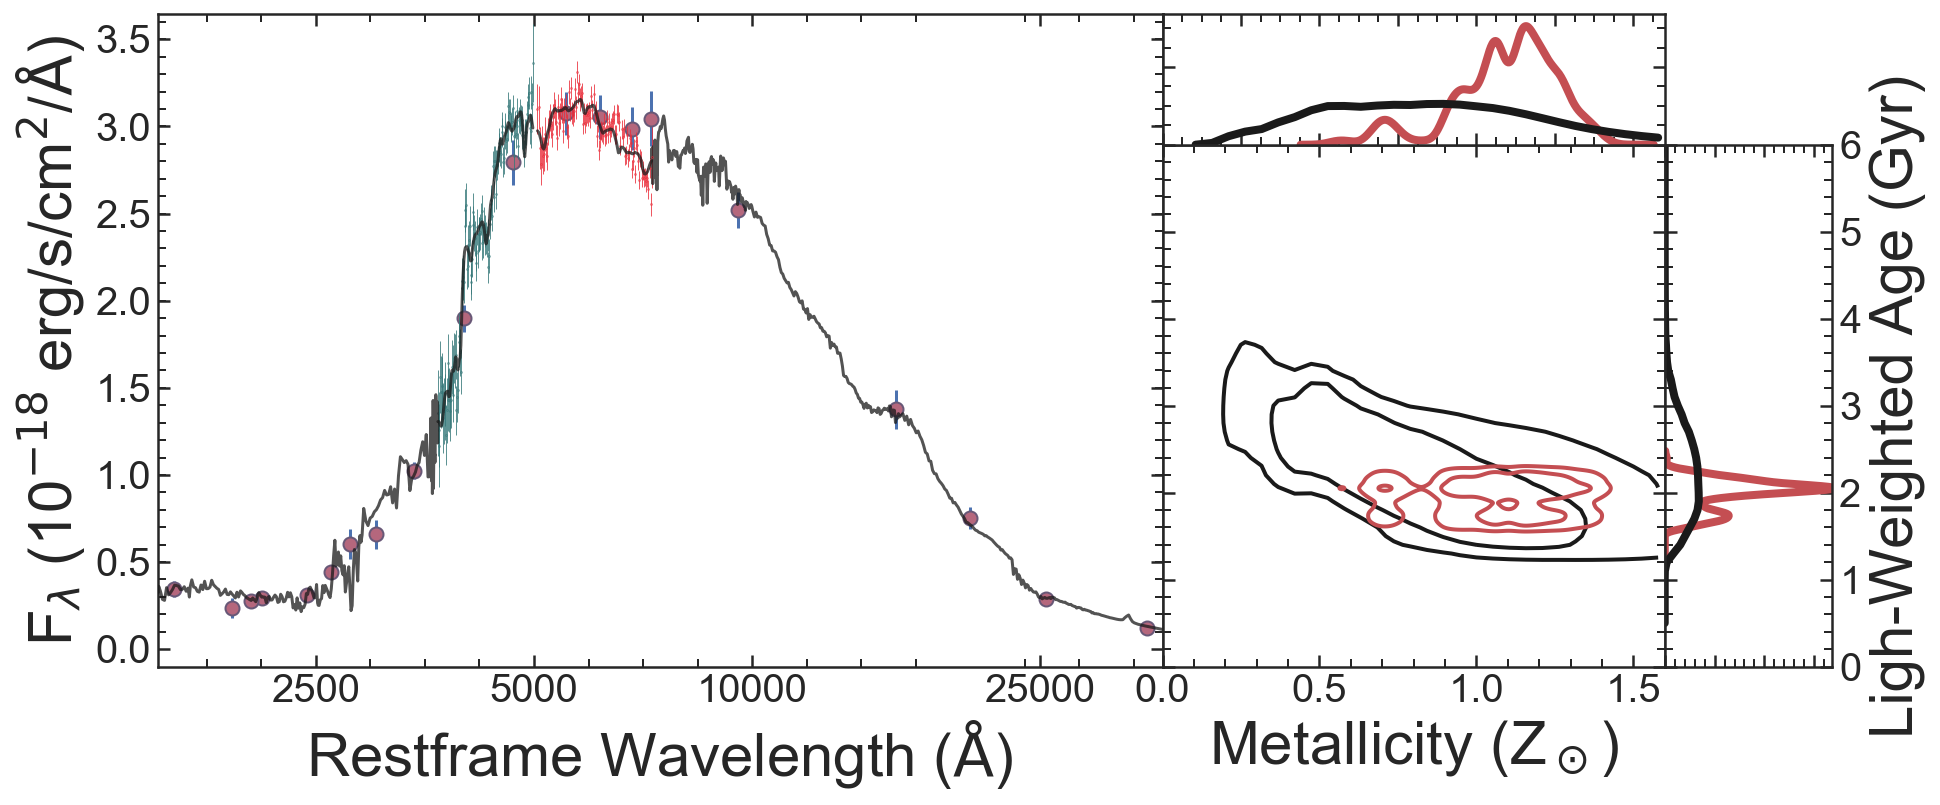

In [129]:
plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(2,3, width_ratios=[6,3,1], height_ratios=[1,4], hspace=0, wspace=0)
##############plot spec##################

ax1 = plt.subplot(gs[0:,0])
if Gs.g102:
    ax1.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
    ax1.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
else:
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

if Gs.g141:
    ax1.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
    ax1.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
else:
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

ax1.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

ax1.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
ax1.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
ax1.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
ax1.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

ax1.set_xticks(np.log10([2500,5000,10000,25000]))
ax1.set_xticklabels(np.array([2500,5000,10000,25000]))
# ax1.legend(fontsize=15, frameon = True, loc = 1)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.minorticks_on()

ax2 = plt.subplot(gs[1,1])
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0.1, light=1.1, as_cmap=True)

plt.contour(M/ 0.019,A,P,levels,linewidths=2, colors = 'k')
plt.contour(M2,A2,MA,levels2,linewidths=2, colors = 'r')

plt.gca().tick_params(axis='y',labelleft='off')
plt.axis([0,1.6,0,6])
ax2.set_xlabel('Metallicity (Z$_\odot$)', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.minorticks_on()

ax3 = plt.subplot(gs[0,1])
plt.plot(x,px, linewidth = 4, color = 'r')
plt.plot(Z/ 0.019,PZ , linewidth = 4, color = 'k')
# ax3.set_xticks([])
# ax3.set_yticks([])
ax3.set_xlim(0,1.6)
ax3.set_ylim(0,max(px)*1.1)
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
ax3.minorticks_on()


ax4 = plt.subplot(gs[1,2])
plt.plot(py,y, linewidth = 4, color = 'r')
plt.plot(PT,T, linewidth = 4, color = 'k')

plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelright='on',labelleft='off')
ax4.set_ylim(0,6)
ax4.set_xlim(min(px),max(px)*1.1)
ax4.minorticks_on()
ax4.set_ylabel('Ligh-Weighted Age (Gyr)', fontsize=30)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax4.yaxis.set_label_position("right")

plt.savefig('../plots/presentation_plots/GND_21156_all_results.png', bbox_inches = 'tight')

In [61]:
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0.1, light=1.1, as_cmap=True)

sea.kdeplot(Zsamp, lwasamp,n_levels = 6,alpha = .8,shade=True,kernel= 'epa',zorder=1, cmap = cmap)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:956: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


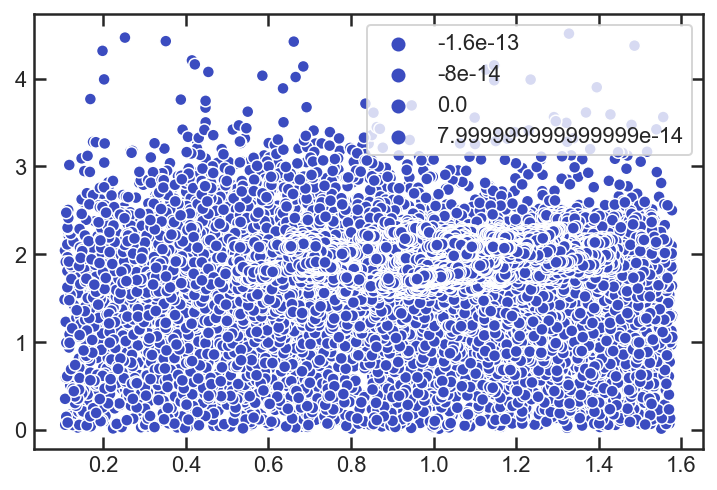

In [57]:
sea.scatterplot(Zsamp, lwasamp, hue=np.exp(dres.logwt)* 1e8, palette='coolwarm')

In [58]:
plt.scatter(dres.samples[:, 0], dres.samples[:, -1], marker='o', c=np.exp(dres.logwt) * 1e8, linewidths=(0.,), cmap='coolwarm')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.


In [115]:
x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm.npy')
y,py = np.load('../data/posteriors/GND_21156_tabfit_Plwa.npy')

ipx = interp1d(x,px, fill_value=0, bounds_error=False)
ipy = interp1d(x,px, fill_value=0, bounds_error=False)

imetal = np.linspace(0.002,0.03,1000)/0.019
iage = np.linspace(0.5,6.0,1000)

M2,A2=np.meshgrid(imetal,iage)

MA = np.ones([len(iage), len(imetal)])

In [116]:
for i in range(len(MA)):
    MA[i] *=ipx(imetal)

for i in range(len(MA.T)):    
    MA.T[i] *=ipy(iage)


In [117]:
plt.contourf(M2, A2, MA)

In [122]:
plt.contour(M2,A2,MA,levels2,linewidths=2)
plt.contour(M/ 0.019,A,P,levels,linewidths=2)

In [132]:
sea.scatterplot(mdb.Re,mdb.z_50)
sea.scatterplot(mdb.query('zgrism > 2').Re,mdb.query('zgrism > 2').z_50)

plt.xscale('log')

In [8]:
sflts = glob(hpath + 'Clear_data/s_flt_files/*')

In [28]:
F_flt = []
for flt in sflts:
    dat = fits.open(flt)
    if dat[0].header['TARGNAME'] == 'GS3' and np.round(dat[0].header['PA_V3'],0) == 193 :
        print(dat[0].header['OBSTYPE'] == 'SPECTROSCOPIC')
        F_flt.append(flt)
#         plt.figure(figsize=[20,20])
#         plt.figure(figsize=[8,8])
    
#         plt.imshow(dat[1].data, vmin = 0.001, vmax = .5)
#         plt.xticks([])
#         plt.yticks([])

True
True
True
True
True
True
True
True


In [26]:
from grizli import combine

In [29]:
combine.combine_flt(F_flt, output='../data/GS4_cmb.fits')

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
Maximum shift (x, y) = (  10.2,   10.4), pad=50
  1 /Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits    0.0    0.0    1102.94
  2 /Users/vestrada/Clear_data/s_flt_files/icxt30s2q_flt.fits   10.2    3.7    1102.94
  3 /Users/vestrada/Clear_data/s_flt_files/icxt30s5q_flt.fits    6.7   10.4    1202.94
  4 /Users/vestrada/Clear_data/s_flt_files/icxt30s7q_flt.fits   -3.5    6.7    1202.94
  5 /Users/vestrada/Clear_data/s_flt_files/icxt31r1q_flt.fits   -0.2    0.1    1102.94
  6 /Users/vestrada/

In [30]:
dat= fits.open('../data/GS4_cmb.fits')

In [39]:
plt.figure(figsize=[20,20])
plt.imshow(dat[1].data, vmin = -0.01, vmax = .3)
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/presentation_plots/GS4_cmb.png', bbox_inches = 'tight')

In [53]:
alldb = pd.read_pickle('../dataframes/fitdb/all_1d_fits.pkl')
Bdb = pd.read_pickle('../dataframes/fitdb/buldgefitsdb.pkl')
sfdb = pd.read_pickle('../Casey_data/SF_db_p1.pkl')
mdb = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

In [54]:
morph_db = alldb.query('UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333]
nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


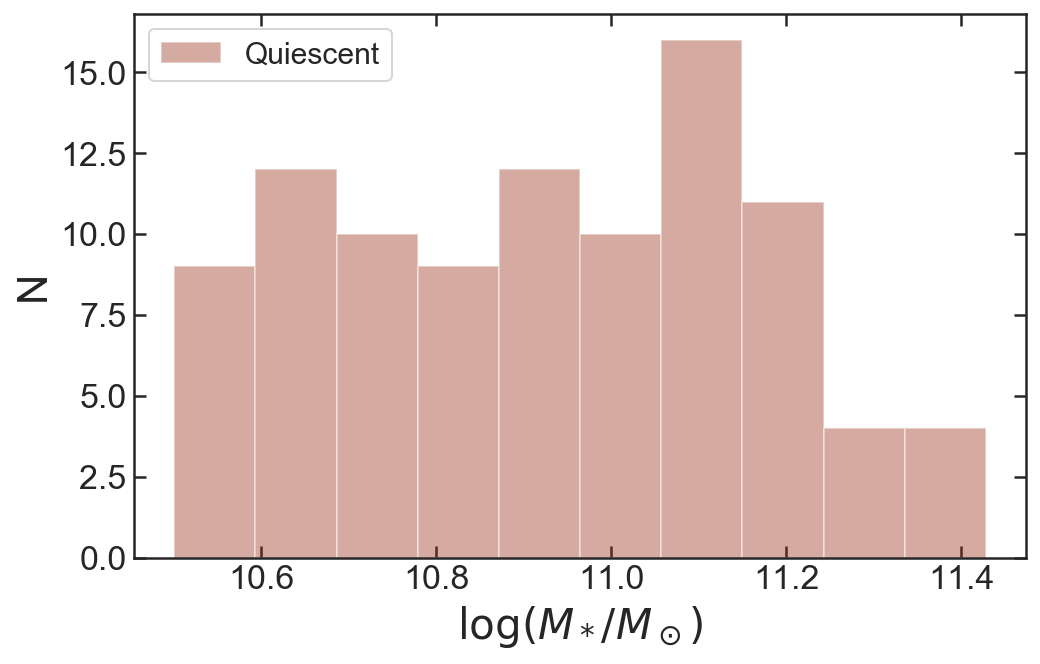

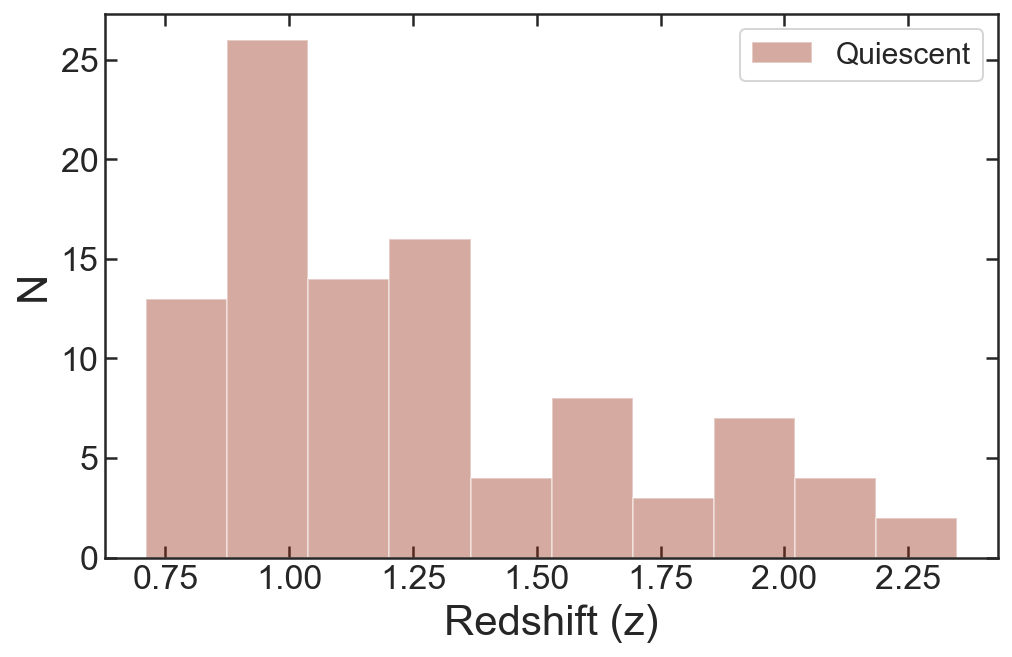

In [58]:
plt.figure(figsize=[8,5])
sea.distplot(mdb.lmass, bins = 10, kde=False, label = 'Quiescent', color = '#972D15')
# sea.distplot(sfdb.lmass, bins = 10, kde=False, label = 'Star-Forming', color = '#81A88D')
# sea.distplot(Bdb.query('lmass > 0 and zgrism > 0').lmass, bins = 10, kde=False, label = 'BD-Quiescent', color = '#D8B70A')
# sea.distplot(Bdb.query('lmass > 0 and zgrism < 0').lmass, bins = 10, kde=False, label = 'BD-Star-Forming', color = '#02401B')

plt.legend(fontsize = 15, loc = 2)
# plt.xlim(9,11.6)
# plt.ylim(0,36)
plt.xlabel('$\log(M_* / M_\odot)$', fontsize=21)
plt.ylabel('N', fontsize=21)   
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../plots/all_lmassdist_1.png', bbox_inches = 'tight')

plt.figure(figsize=[8,5])
sea.distplot(mdb.zgrism, bins = 10, kde=False, label = 'Quiescent', color = '#972D15')
# sea.distplot(sfdb.zgrism, bins = 10, kde=False, label = 'Star-Forming', color = '#81A88D')
# sea.distplot(Bdb.query('lmass > 0 and zgrism > 0').zgrism, bins = 10, kde=False, label = 'BD-Quiescent', color = '#D8B70A')
# sea.distplot(Bdb.query('lmass > 0 and zgrism < 0').z_grizli, bins = 10, kde=False, label = 'BD-Star-Forming', color = '#02401B')

plt.legend(fontsize = 15, loc = 1)
# plt.xlim(0.25,3.5)
# plt.ylim(0,48)

plt.xlabel('Redshift (z)', fontsize=21)
plt.ylabel('N', fontsize=21)   
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../plots/all_rshiftdist_1.png', bbox_inches = 'tight')


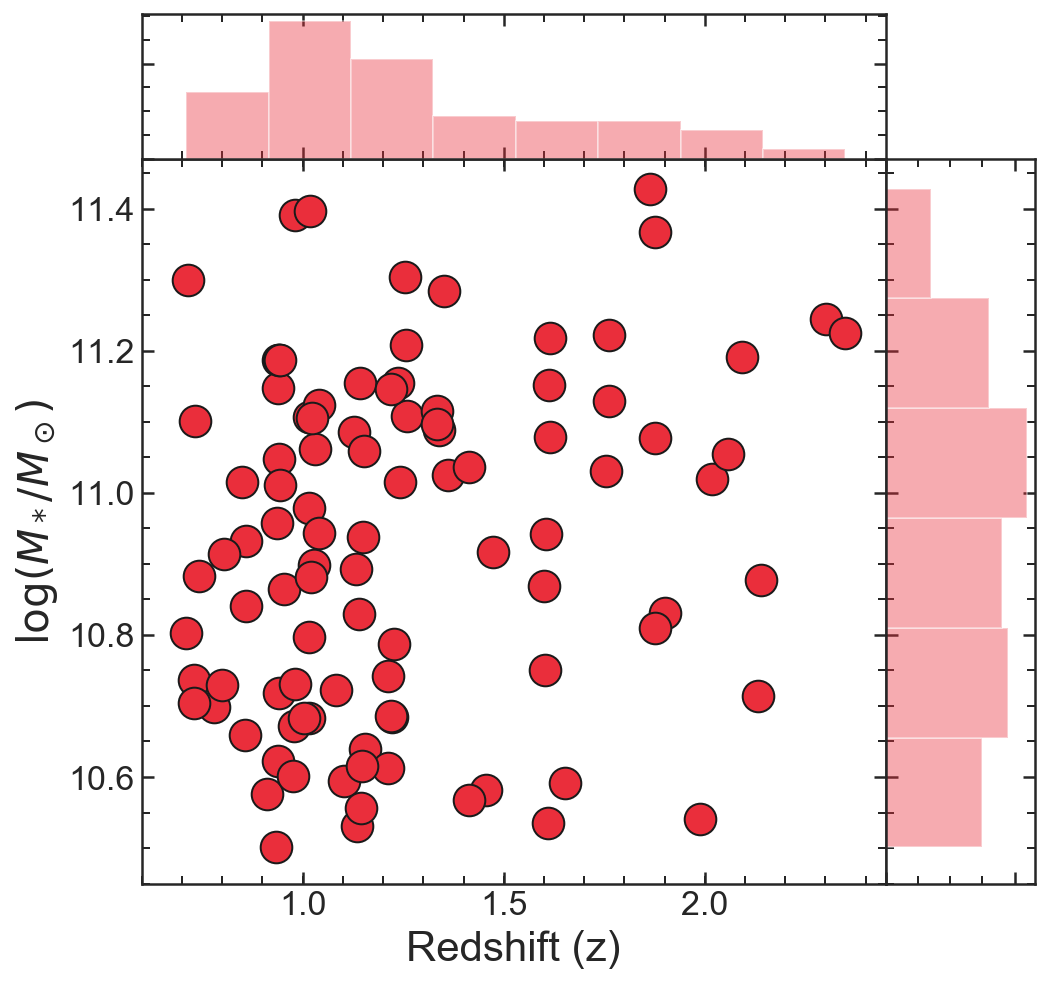

In [111]:
gs = gridspec.GridSpec(2,2, wspace=0, hspace=0, width_ratios=[5,1], height_ratios=[1,5])

plt.figure(figsize=[8,8])
ax1 = plt.subplot(gs[1,0])
plt.scatter(mdb.zgrism,mdb.lmass, color = '#EA2E3B', s=250, edgecolors = 'k')# scatter_kws = {'edgecolors':'k'})
ax1.set_xlim(0.6,2.45)
ax1.set_ylim(10.45,11.47)
ax1.minorticks_on()
ax1.set_xticks(np.arange(0.6,2.5,0.1), minor=True)

plt.ylabel('$\log(M_* / M_\odot)$', fontsize=21)
plt.xlabel('Redshift (z)', fontsize=21)   
plt.tick_params(axis='both', which='major', labelsize=17)

ax2 = plt.subplot(gs[0,0])
sea.distplot(mdb.zgrism, kde=False, label = 'Quiescent', color = '#EA2E3B', ax = ax2)
ax2.set_xlabel('')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlim(0.6,2.45)
ax2.set_xticks([1,1.5,2.0])
ax2.set_xticks(np.arange(0.6,2.5,0.1), minor=True)
ax2.minorticks_on()

ax3 = plt.subplot(gs[1,1])
sea.distplot(mdb.lmass, kde=False, label = 'Quiescent', color = '#EA2E3B', ax = ax3, vertical=True)
ax3.set_ylabel('')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_ylim(10.45,11.47)
ax3.minorticks_on()

plt.savefig('../plots/all_rshiftdist_app.png', bbox_inches = 'tight')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


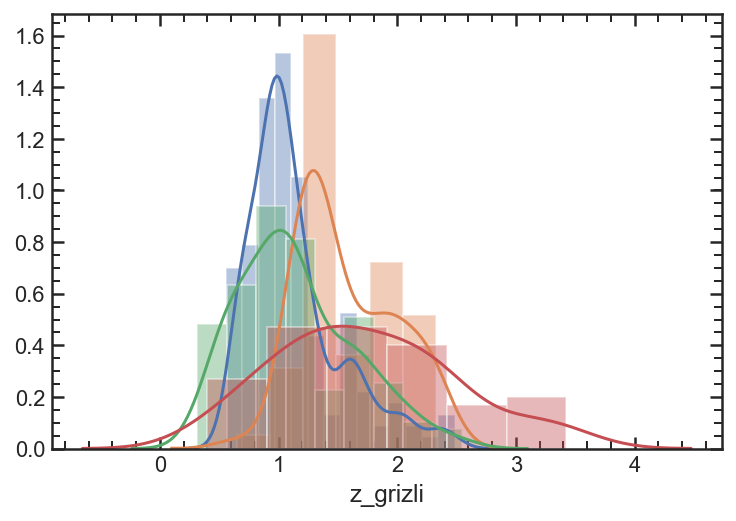

In [10]:
sea.distplot(mdb.zgrism)
sea.distplot(sfdb.zgrism)
sea.distplot(Bdb.query('lmass > 0 and zgrism > 0').zgrism)
sea.distplot(Bdb.query('lmass > 0 and zgrism < 0').z_grizli)



/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


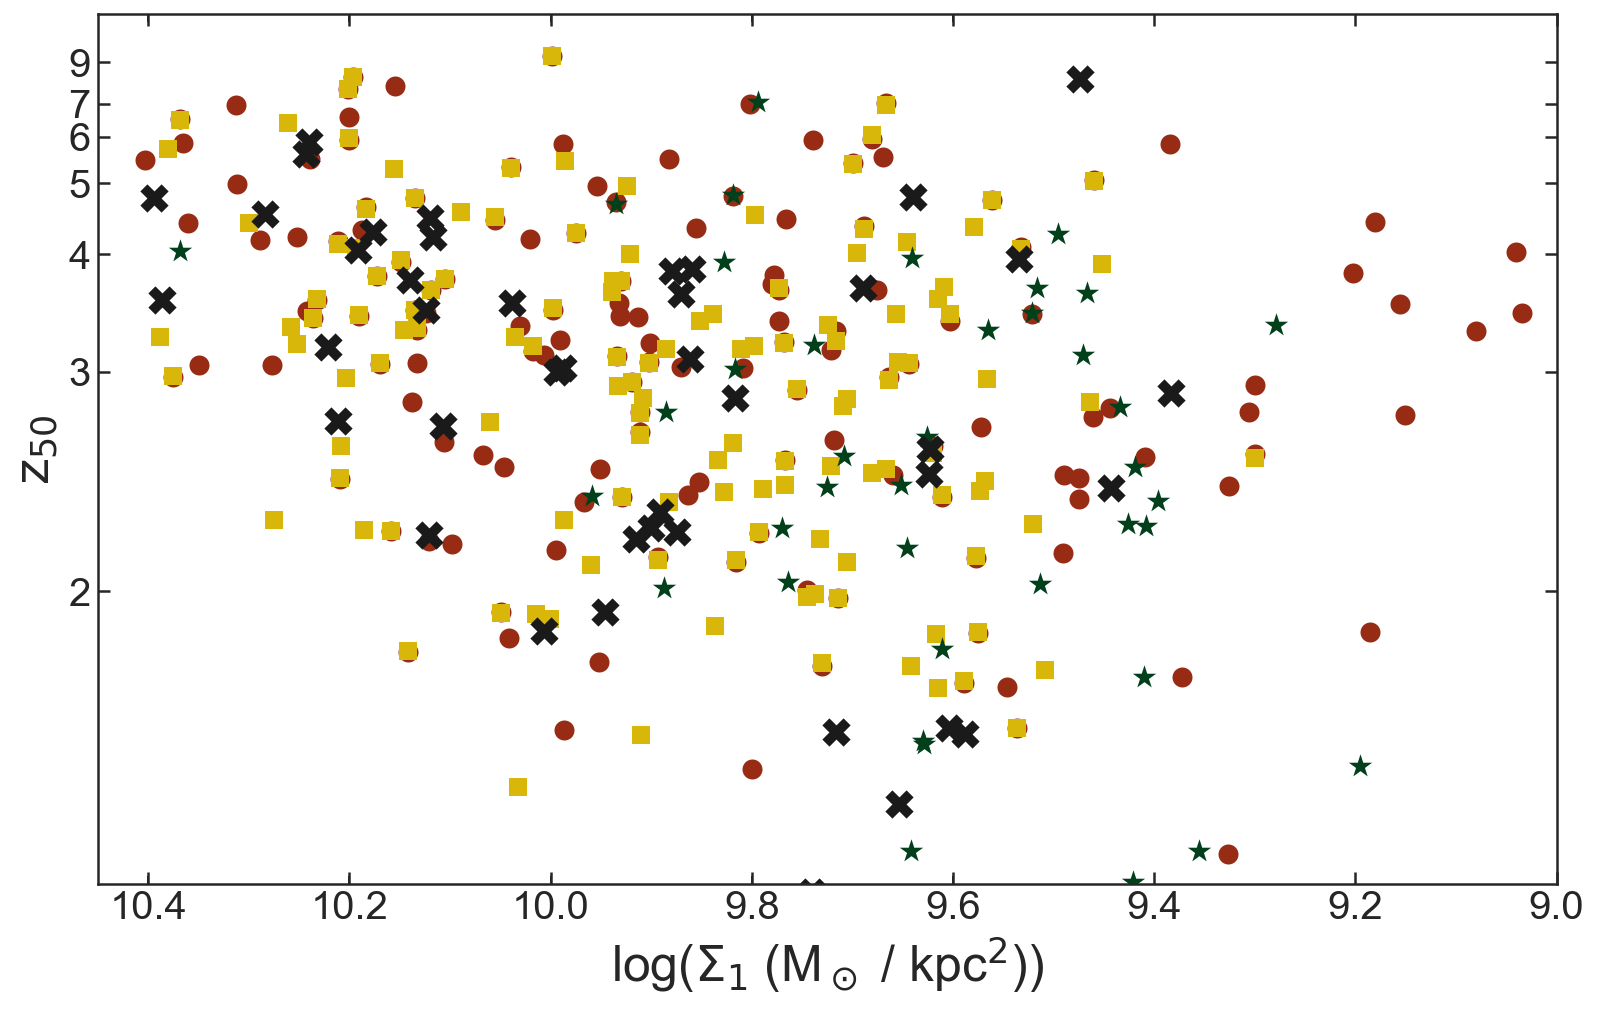

In [75]:
gs = gridspec.GridSpec(2,2,width_ratios=[2,1],hspace=0.08,wspace=0.04)

plt.figure(figsize=[20,8])

ax1 = plt.subplot(gs[:,0])

sea.scatterplot(np.log10(mdb.Sigma1), 
                cosmo.lookback_time(mdb.z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#982B14', s = 100, marker = 'o', label = 'Compact')

sea.scatterplot(np.log10(Bdb.query('log_ssfr < -11 and AGN != "AGN"').Sigma1), 
                cosmo.lookback_time(Bdb.query('log_ssfr < -11 and AGN != "AGN"').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#D8B70A', s = 80, marker = 's', label = 'Extended')

sea.scatterplot(np.log10(Bdb.query('log_ssfr > -11 and AGN != "AGN"').Sigma1), 
                cosmo.lookback_time(Bdb.query('log_ssfr > -11 and AGN != "AGN"').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = '#02401B', s = 150, marker = '*', label = '')

sea.scatterplot(np.log10(Bdb.query('AGN == "AGN"').Sigma1), 
                cosmo.lookback_time(Bdb.query('AGN == "AGN"').z_50),  linewidth = 0,legend=False,
                sizes=(20, 200), ax=ax1, color = 'k', s = 200, marker = 'X', label = '')

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_yticklabels([2,3,4,5,6,7,9])
ax1.minorticks_off()

ax1.set_xticks([ 10.4, 10.2, 10.0, 9.8, 9.6], minor=True)
plt.xlim(10.45,9.0)
plt.ylim(9,13.5)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)


plt.savefig('../plots/compact_sig1_all.png', bbox_inches = 'tight')

# forward modeling plot

In [10]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0)

In [11]:
wave,flux = sp.get_spectrum(tage = 2, peraa=True)

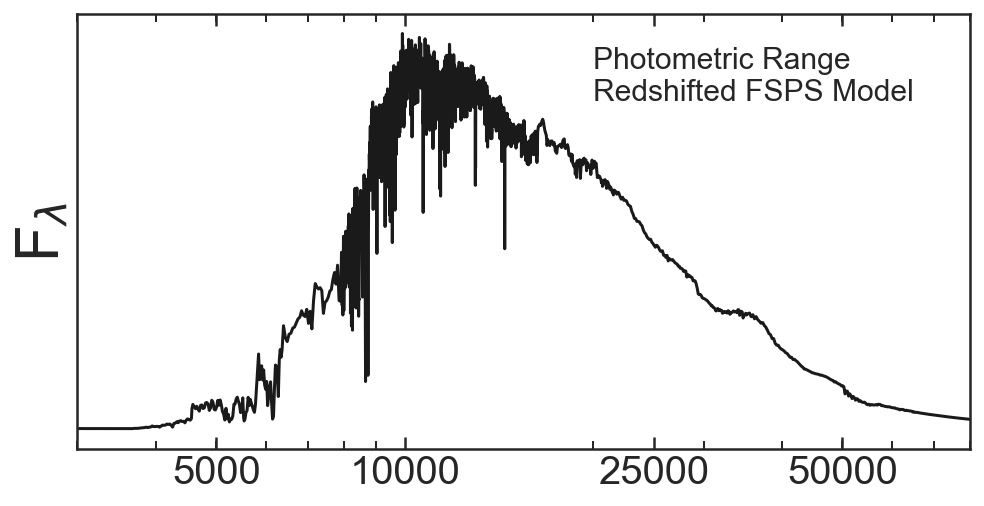

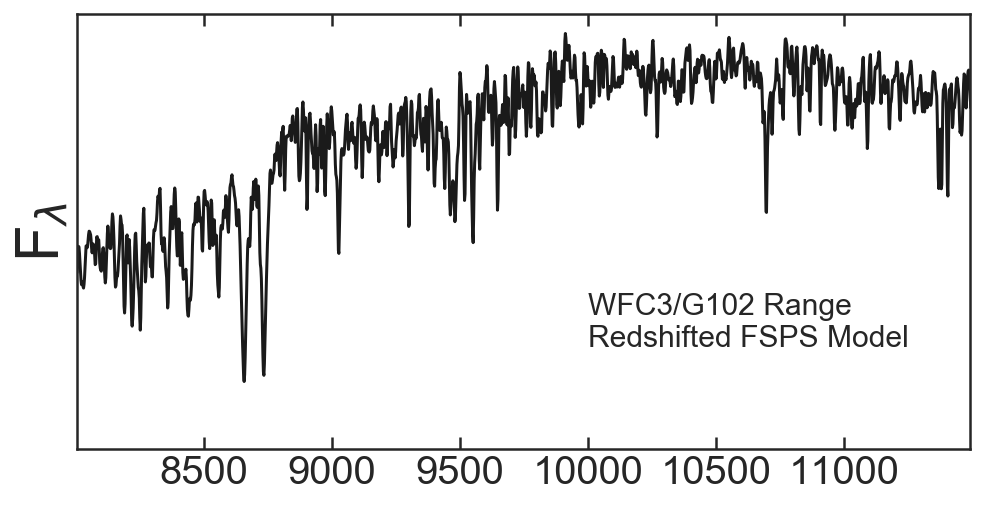

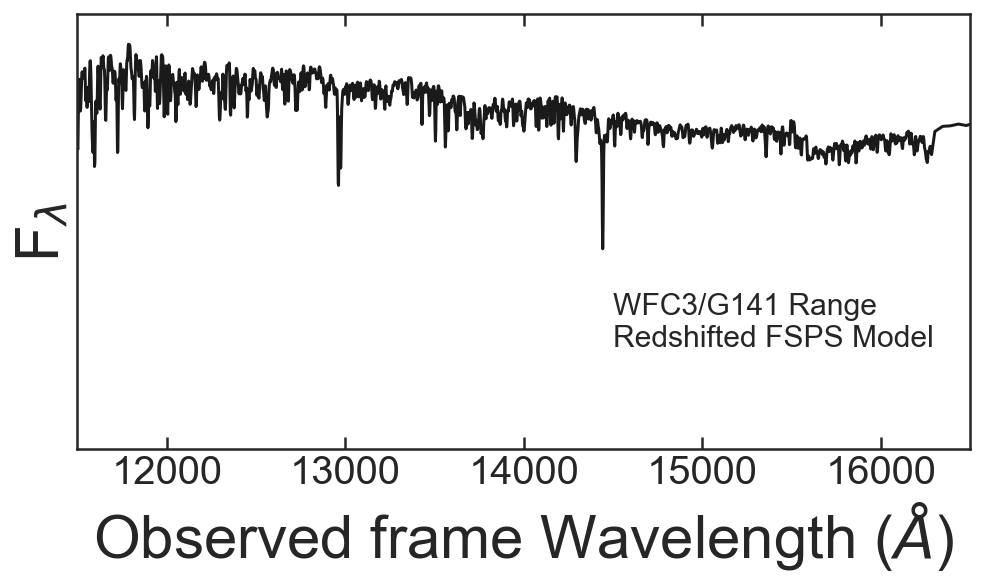

In [34]:
plt.figure(figsize=[8,4])
plt.plot(wave*(1+1.2),flux, 'k')
plt.xlim(3000,80000)
plt.xscale('log')
plt.yticks([])
plt.ylabel('F$_\lambda$', fontsize = 30)
# plt.xlabel('Observed frame Wavelength ($\AA$)', fontsize = 30)
plt.xticks([5000,10000,25000,50000],[5000,10000,25000,50000])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.text(20000,0.00008, 'Photometric Range\nRedshifted FSPS Model', fontsize=15)
plt.savefig('../plots/phot_fsps.png', bbox_inches = 'tight')

plt.figure(figsize=[8,4])
plt.plot(wave*(1+1.2),flux, 'k')
plt.xlim(8005,11495)
plt.yticks([])
plt.ylabel('F$_\lambda$', fontsize = 30)
# plt.xlabel('Observed frame Wavelength ($\AA$)', fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.text(10000,0.00002, 'WFC3/G102 Range\nRedshifted FSPS Model', fontsize=15)
plt.savefig('../plots/g102_fsps.png', bbox_inches = 'tight')

plt.figure(figsize=[8,4])
plt.plot(wave*(1+1.2),flux, 'k')
plt.xlim(11500,16500)
plt.yticks([])
plt.ylabel('F$_\lambda$', fontsize = 30)
plt.xlabel('Observed frame Wavelength ($\AA$)', fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.text(14500,0.00002, 'WFC3/G141 Range\nRedshifted FSPS Model', fontsize=15)
plt.savefig('../plots/g141_fsps.png', bbox_inches = 'tight')

In [35]:
from spec_tools import Photometry

In [36]:
phot = Photometry(wave,flux, np.ones_like(flux),1)

In [37]:
masterlist = '../phot/master_template_list.pkl'
master_tmp_df = pd.read_pickle(masterlist)

In [48]:
wvs = []
filt = []
for i in master_tmp_df[:47].index:
    phot.Get_Sensitivity(master_tmp_df.tmp_num[i])
    wvs.append(phot.sens_wv)
    filt.append(phot.trans)

([<matplotlib.axis.XTick at 0x1a8a4efd30>,
 <a list of 4 Text xticklabel objects>)

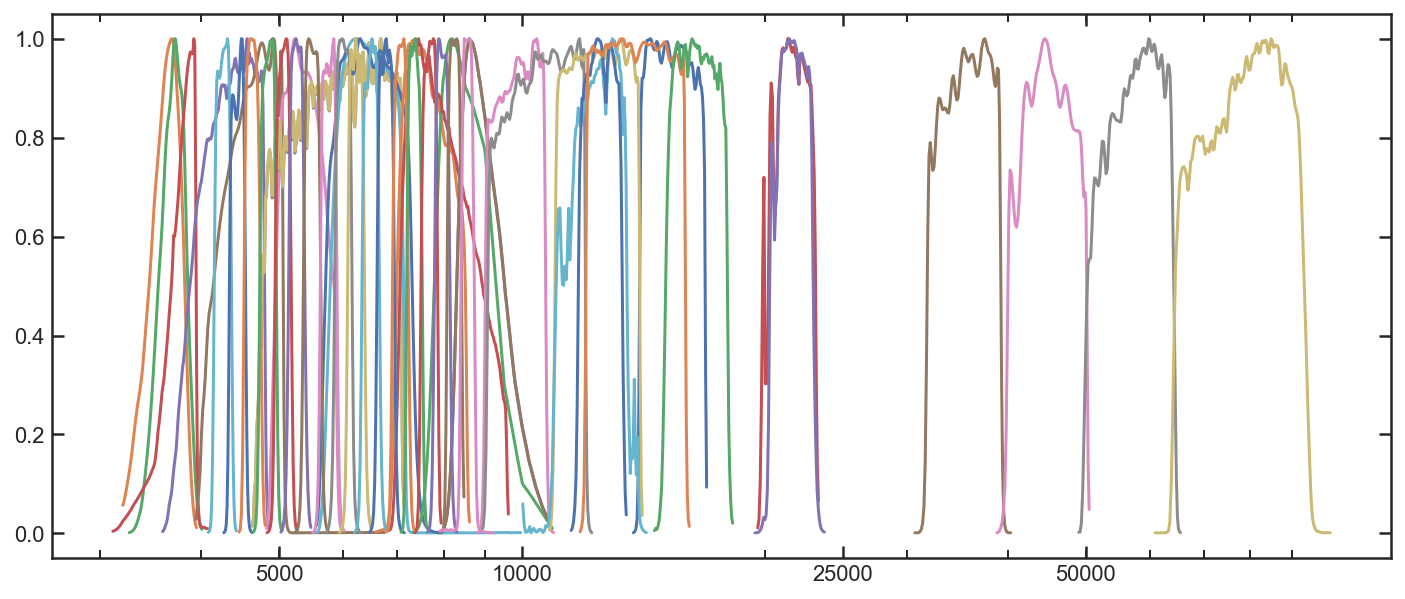

In [51]:
plt.figure(figsize=[12,5])

for i in range(len(wvs)):
        plt.plot(wvs[i], filt[i])
        
plt.xscale('log')
plt.xticks([5000,10000,25000,50000],[5000,10000,25000,50000])


In [47]:
master_tmp_df[:47]

eff_wv        tmp_name  tmp_num
0   15351.344722       S_f_F160W      205
1    3600.082720         S_f_U50      105
2    3682.145363         S_f_U38      107
3    3742.285118           S_f_U      103
4    4298.072291       S_f_F435W        1
5    4575.176509           S_f_B       46
6    5359.540830           S_f_V       50
7    5843.900138   S_f_F606Wcand      236
8    5842.073355       S_f_F606W        4
9    6417.607881           S_f_R      260
10   6464.700932          S_f_Rc       54
11   7668.292651       S_f_F775W        5
12   8594.902017           S_f_I       58
13   8002.504973   S_f_F814Wcand      239
14   9004.238016      S_f_F850LP        7
15   9001.008862  S_f_F850LPcand      240
16   9840.877482       S_f_F098M      201
17  10475.921990       S_f_F105W      202
18  12409.718601       S_f_F125W      203
19  12311.046696           S_f_J       34
20  12512.531568      S_f_tenisJ      220
21  13830.660535       S_f_F140W      204
22  16451.453195           S_f_H       36
23  21534.133751      S_f_tenisK      222
24  21638.252425          S_f_Ks       37
25  35439.798109       S_f_IRAC1       18
26  44839.150692       S_f_IRAC2       19
27  57164.227713       S_f_IRAC3       20
28  78285.067608       S_f_IRAC4       21
29   4258.979444       S_f_IA427      181
30   4441.752692       S_f_IA445      182
31   4632.203645       S_f_IA464      183
32   4846.137152       S_f_IA484      184
33   5059.708632       S_f_IA505      185
34   5257.994811       S_f_IA527      186
35   5493.629098       S_f_IA550      187
36   5761.596165       S_f_IA574      188
37   6005.681223       S_f_IA598      189
38   6229.137630       S_f_IA624      190
39   6496.687052       S_f_IA651      191
40   6779.894635       S_f_IA679      192
41   7072.002577       S_f_IA709      193
42   7357.843792       S_f_IA738      194
43   7678.582888       S_f_IA767      195
44   7964.482551       S_f_IA797      196
45   8244.831031       S_f_IA827      197
46   8563.218738       S_f_IA856      198

In [141]:
# mb = multifit.MultiBeam('../beams/GS4_20788.beams.fits', **args)
mb = multifit.MultiBeam('../beams/GN2_21738.beams.fits', **args)

1 icat21cfq_flt.fits G102
2 icat21coq_flt.fits G102
3 icat21dgq_flt.fits G102
4 icat21dlq_flt.fits G102
5 icxt55krq_flt.fits G102
6 icxt55ksq_flt.fits G102
7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3721xiq_flt.fits G141
26 ib3721xmq_flt.fits G141
27 ib3721xyq_flt.fits G141
28 ib3721y2q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


In [142]:
img = IMG_pull('GND', 21738)

img_scale : asinh
img_scale : asinh
img_scale : asinh


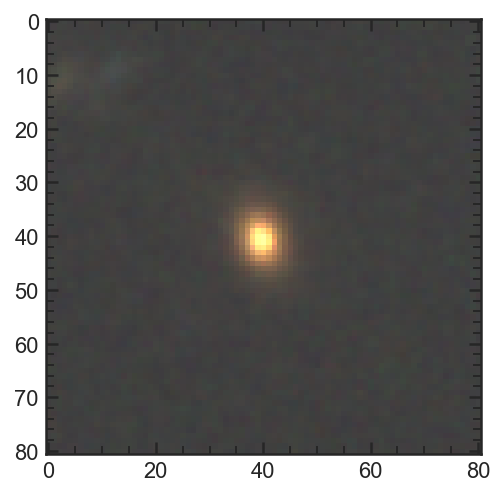

In [126]:
plt.imshow(img)

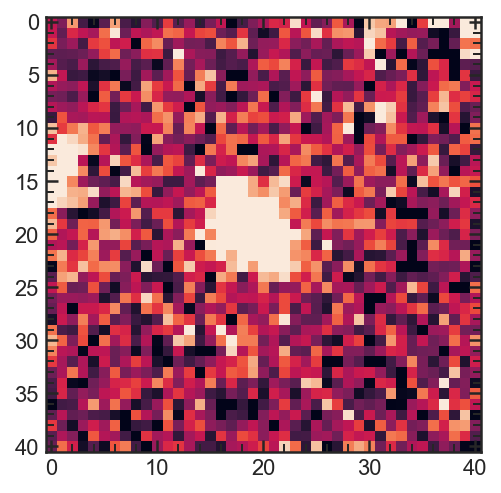

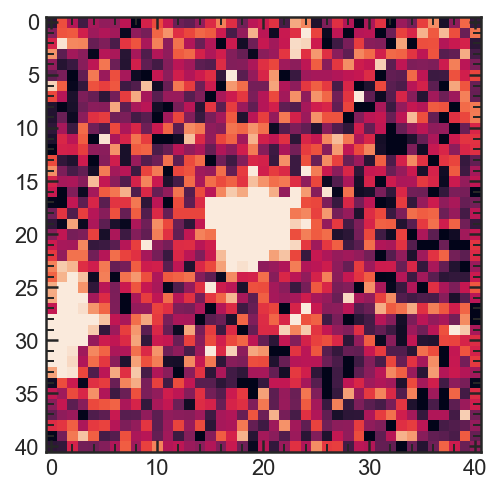

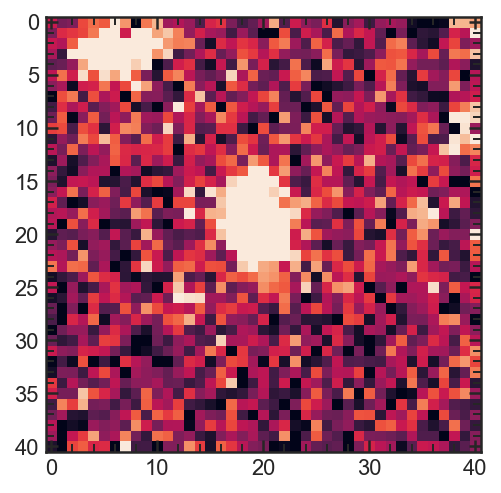

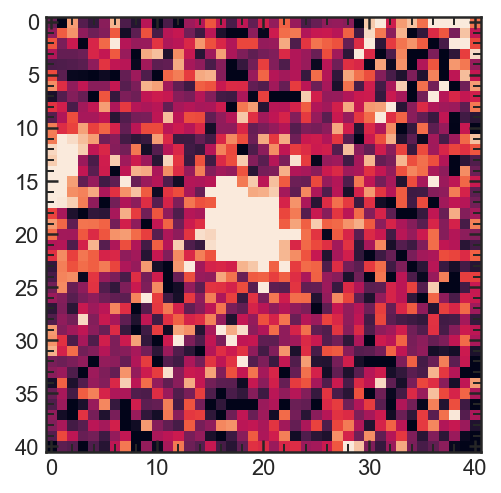

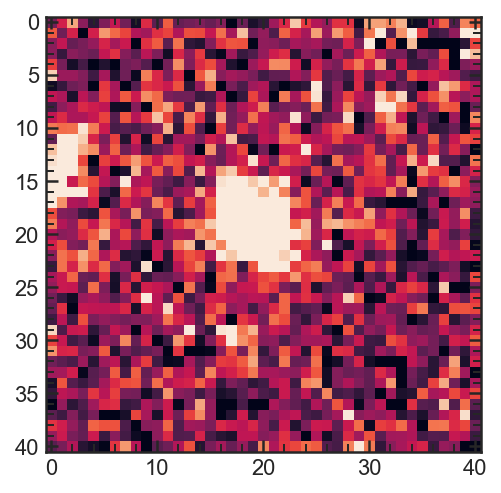

In [127]:
pa = 0
for b in mb.beams:
    if b.get_dispersion_PA() != pa:
        pa = b.get_dispersion_PA()
        plt.figure()
        plt.imshow(np.arcsinh(b.beam.direct[60:101,60:101]), 
                   vmin =np.percentile(np.arcsinh(b.beam.direct[60:101,60:101]),5), 
                   vmax = np.percentile(np.arcsinh(b.beam.direct[60:101,60:101]),95))

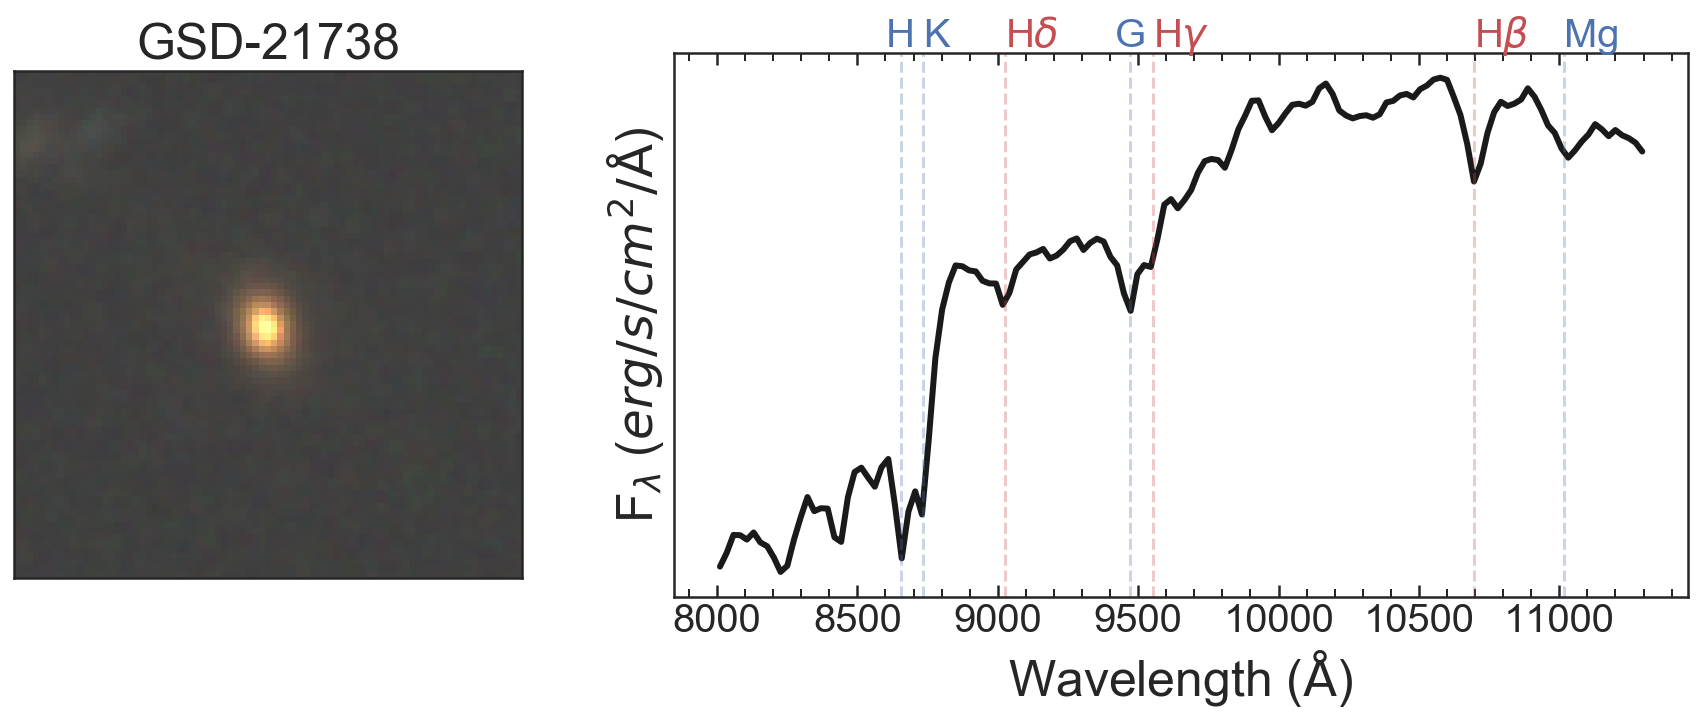

In [172]:
gs = gridspec.GridSpec(1,2,width_ratios=(1,2))

plt.figure(figsize=[15,5])
plt.subplot(gs[0])

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('GSD-21738', fontsize=25)

plt.subplot(gs[1])
pa = 0
for b in mb.beams:
    if b.get_dispersion_PA() != pa and b.grism.filter == 'G102':
        pa = b.get_dispersion_PA()
        b.beam.compute_model(spectrum_1d=[wave*(1 + 1.2), flux])
        w, f, e = b.beam.optimal_extract(b.beam.model, bin=0)
        b.beam.compute_model(spectrum_1d=[wave*(1 + 1.2), np.ones_like(flux)])
        w, fl, e = b.beam.optimal_extract(b.beam.model, bin=0)

        IDX = [U for U in range(len(w)) if 8000 < w[U] < 11300]
        plt.plot(w[IDX],f[IDX]/fl[IDX], color = 'k', linewidth = 3)
        break
        
plt.yticks([])
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.axvline(4102.89 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(3934.777 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(3969.588 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(4305.61 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')

plt.text(4102.89 * (1 + 1.2), 0.000092, 'H$\delta$', color = 'r', fontsize=20)
plt.text(4341.68 * (1 + 1.2), 0.000092, 'H$\gamma$', color = 'r', fontsize=20)
plt.text(4862.68 * (1 + 1.2), 0.000092, 'H$\\beta$', color = 'r', fontsize=20)
plt.text(5008.240 * (1 + 1.2), 0.000092, 'Mg', color= 'b', fontsize=20)
plt.text(3910 * (1 + 1.2), 0.000092, 'H', color= 'b', fontsize=20)
plt.text(3969.588 * (1 + 1.2), 0.000092, 'K', color= 'b', fontsize=20)
plt.text(4280 * (1 + 1.2), 0.000092, 'G', color= 'b', fontsize=20)

plt.savefig('../plots/GSD-21738_imgspec.png',bbox_inches = 'tight')

In [35]:
b.grism.instrument

'WFC3'

In [173]:
mb = multifit.MultiBeam('../beams/GS2_45775.beams.fits', **args)
# mb = multifit.MultiBeam('../beams/GS3_34671.beams.fits', **args)25799

1 ibhj11hiq_flt.fits G141
2 ibhj11hpq_flt.fits G141
3 ibhj11hwq_flt.fits G141
4 ibhj11i3q_flt.fits G141
5 ibhj03xoq_flt.fits G141
6 ibhj03xvq_flt.fits G141
7 ibhj03y2q_flt.fits G141
8 ibhj03y9q_flt.fits G141
9 icxt01cgq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


10 icxt01ciq_flt.fits G102
11 icxt01clq_flt.fits G102
12 icxt01cnq_flt.fits G102
13 icxt02c7q_flt.fits G102
14 icxt02caq_flt.fits G102
15 icxt02cdq_flt.fits G102
16 icxt02cfq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


In [174]:
img = IMG_pull('GSD', 45775)

img_scale : asinh
img_scale : asinh
img_scale : asinh


0.24359606802463532

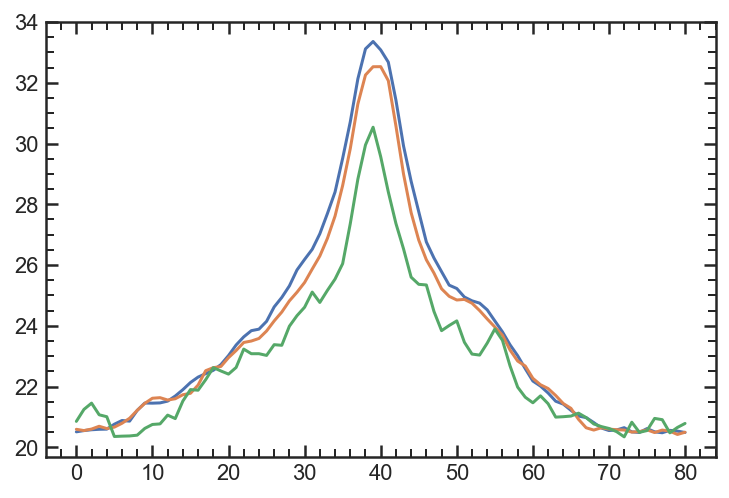

In [136]:
plt.plot(sum(img))
np.percentile(img,5)

In [140]:
plt.imshow(img,)

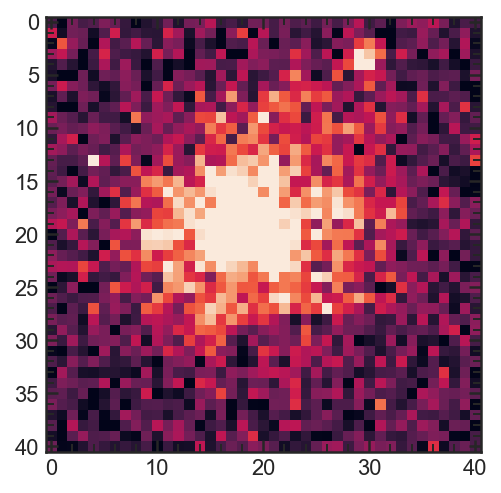

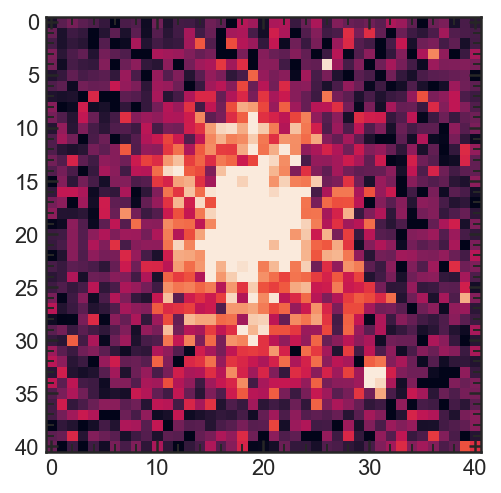

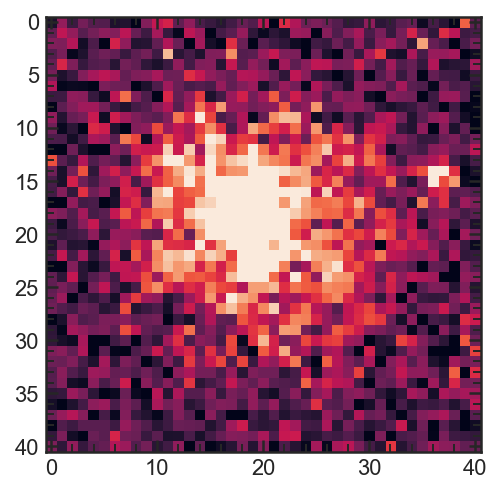

In [133]:
pa = 0
for b in mb.beams:
    if b.get_dispersion_PA() != pa:
        pa = b.get_dispersion_PA()
        plt.figure()
        plt.imshow(np.arcsinh(b.beam.direct[60:101,60:101]), 
                   vmin =np.percentile(np.arcsinh(b.beam.direct[60:101,60:101]),5), 
                   vmax = np.percentile(np.arcsinh(b.beam.direct[60:101,60:101]),95))

In [177]:
pa = 0
for b in mb.beams:
    if b.get_dispersion_PA() != pa and b.grism.filter == 'G102':
        pa = b.get_dispersion_PA()
        b.beam.compute_model(spectrum_1d=[wave*(1 + 1.2), flux])
        w, f, e = b.beam.optimal_extract(b.beam.model, bin=0)
        gs = gridspec.GridSpec(1,2,width_ratios=(1,2))

plt.figure(figsize=[15,5])
plt.subplot(gs[0])

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('GSD-45775', fontsize=25)

plt.subplot(gs[1])
pa = 0
for b in mb.beams:
    if b.get_dispersion_PA() != pa and b.grism.filter == 'G102':
        pa = b.get_dispersion_PA()
        b.beam.compute_model(spectrum_1d=[wave*(1 + 1.2), flux])
        w, f, e = b.beam.optimal_extract(b.beam.model, bin=0)
        b.beam.compute_model(spectrum_1d=[wave*(1 + 1.2), np.ones_like(flux)])
        w, fl, e = b.beam.optimal_extract(b.beam.model, bin=0)

        IDX = [U for U in range(len(w)) if 8000 < w[U] < 11300]
        plt.plot(w[IDX],f[IDX]/fl[IDX], color = 'k', linewidth = 3)
        break
        
plt.yticks([])
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.axvline(4102.89 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(3934.777 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(3969.588 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(4305.61 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')

plt.text(4102.89 * (1 + 1.2), 0.000092, 'H$\delta$', color = 'r', fontsize=20)
plt.text(4341.68 * (1 + 1.2), 0.000092, 'H$\gamma$', color = 'r', fontsize=20)
plt.text(4862.68 * (1 + 1.2), 0.000092, 'H$\\beta$', color = 'r', fontsize=20)
plt.text(5008.240 * (1 + 1.2), 0.000092, 'Mg', color= 'b', fontsize=20)
plt.text(3910 * (1 + 1.2), 0.000092, 'H', color= 'b', fontsize=20)
plt.text(3969.588 * (1 + 1.2), 0.000092, 'K', color= 'b', fontsize=20)
plt.text(4280 * (1 + 1.2), 0.000092, 'G', color= 'b', fontsize=20)

plt.savefig('../plots/GSD-45775_imgspec.png',bbox_inches = 'tight')

In [178]:
mb = multifit.MultiBeam('../beams/GS3_34671.beams.fits', **args)

1 ibhj33tiq_flt.fits G141
2 ibhj33tpq_flt.fits G141
3 ibhj33twq_flt.fits G141
4 ibhj33u3q_flt.fits G141
5 icxt32nlq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


6 icxt32nmq_flt.fits G102
7 icxt32npq_flt.fits G102
8 icxt32nrq_flt.fits G102
9 icxt33roq_flt.fits G102
10 icxt33rpq_flt.fits G102
11 icxt33rsq_flt.fits G102
12 icxt33ruq_flt.fits G102
13 icxt30s0q_flt.fits G102
14 icxt30s2q_flt.fits G102
15 icxt30s5q_flt.fits G102
16 icxt30s7q_flt.fits G102
17 icxt31r1q_flt.fits G102
18 icxt31r3q_flt.fits G102
19 icxt31r6q_flt.fits G102
20 icxt31r8q_flt.fits G102
21 icxt34ekq_flt.fits G102
22 icxt34erq_flt.fits G102
23 icxt35s4q_flt.fits G102
24 icxt35sbq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)


In [179]:
img = IMG_pull('GSD', 34671)

img_scale : asinh
img_scale : asinh
img_scale : asinh


In [188]:
185.0 -129.0, 185 - 149.0

(56.0, 36.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


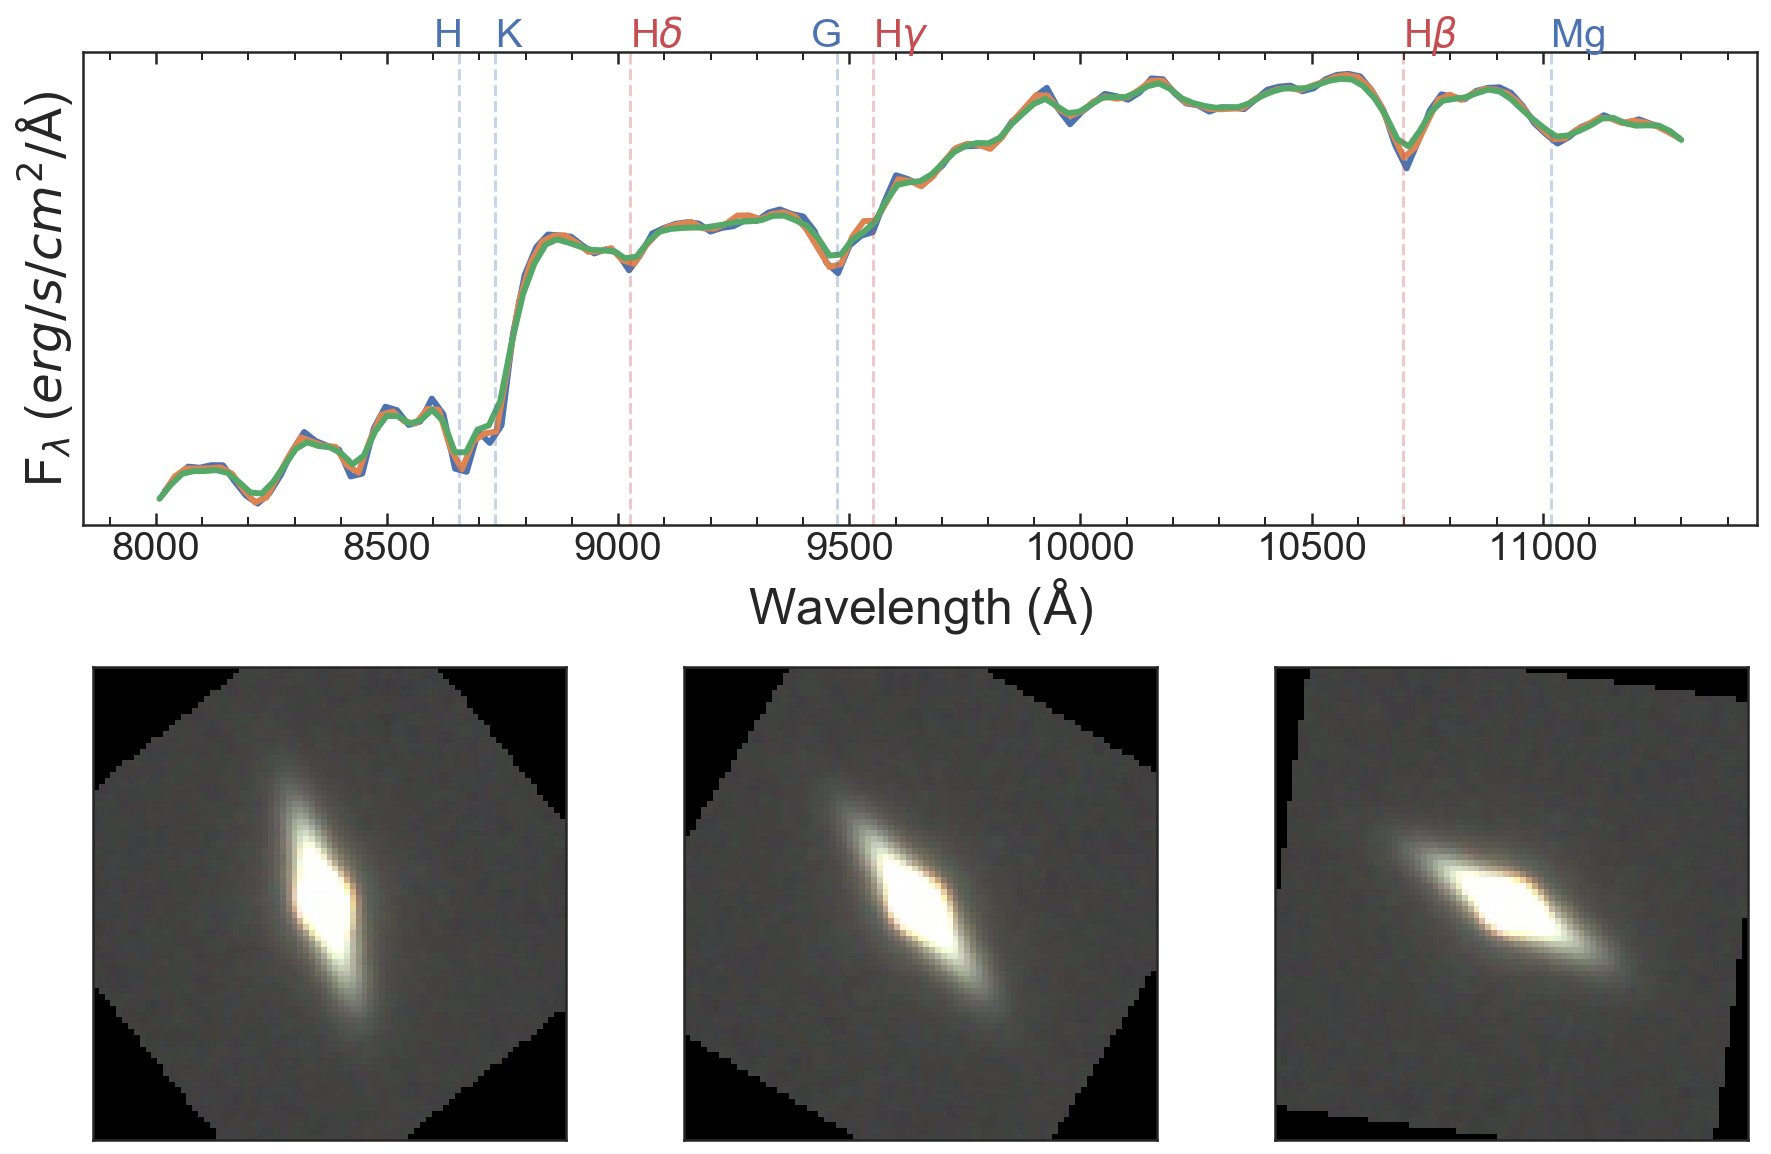

In [216]:
import scipy

gs = gridspec.GridSpec(2,3, hspace = 0.3)

plt.figure(figsize=[15,10])
plt.subplot(gs[0])

plt.subplot(gs[1,0])
plt.imshow(scipy.ndimage.rotate(img,angle=129 + 90 )[17:98,17:98])
plt.xticks([])
plt.yticks([])

plt.subplot(gs[1,1])
plt.imshow(scipy.ndimage.rotate(img,angle=149 + 90 )[15:96,15:96])
plt.xticks([])
plt.yticks([])

plt.subplot(gs[1,2])
plt.imshow(scipy.ndimage.rotate(img,angle=172 + 90 )[5:86,5:86])
plt.xticks([])
plt.yticks([])

plt.subplot(gs[0,:])
pa = 0
for b in mb.beams:
    if b.get_dispersion_PA() != pa and b.grism.filter == 'G102':
        pa = b.get_dispersion_PA()
        b.beam.compute_model(spectrum_1d=[wave*(1 + 1.2), flux])
        w, f, e = b.beam.optimal_extract(b.beam.model, bin=0)
        b.beam.compute_model(spectrum_1d=[wave*(1 + 1.2), np.ones_like(flux)])
        w, fl, e = b.beam.optimal_extract(b.beam.model, bin=0)

        IDX = [U for U in range(len(w)) if 8000 < w[U] < 11300]
        
        plt.plot(w[IDX],f[IDX]/fl[IDX], linewidth = 3)
        
plt.yticks([])
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.axvline(4102.89 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + 1.2),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(3934.777 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(3969.588 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')
plt.axvline(4305.61 * (1 + 1.2),linestyle='--', alpha=.3, color= 'b')

plt.text(4102.89 * (1 + 1.2), 0.000092, 'H$\delta$', color = 'r', fontsize=20)
plt.text(4341.68 * (1 + 1.2), 0.000092, 'H$\gamma$', color = 'r', fontsize=20)
plt.text(4862.68 * (1 + 1.2), 0.000092, 'H$\\beta$', color = 'r', fontsize=20)
plt.text(5008.240 * (1 + 1.2), 0.000092, 'Mg', color= 'b', fontsize=20)
plt.text(3910 * (1 + 1.2), 0.000092, 'H', color= 'b', fontsize=20)
plt.text(3969.588 * (1 + 1.2), 0.000092, 'K', color= 'b', fontsize=20)
plt.text(4280 * (1 + 1.2), 0.000092, 'G', color= 'b', fontsize=20)

plt.savefig('../plots/GSD-34671_allimgspec.png',bbox_inches = 'tight')